<a href="https://colab.research.google.com/github/Dicere/tests_SHIFT/blob/main/Testovoe_SHIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Данное тестовое было для того чтобы поступить на курсы SHIFT, задание проходило в формате соревнования на Kaggle
#Постановка задачи
###Оценка модели будет делаться по метрике Gini:
###Gini = 2 * AUC - 1 где AUC - это ROC AUC.

###Для построения модели, участникам предоставляется обучающий набор клиентов train.csv с информацией о наличии коммуникации (treatment_flg) и совершение покупки (purchased).

###Необходимо для каждого клиента из тестовой выборки test.csv предсказать target, который равен 1 если после коммуникации покупка совершена и если без коммуникации покупка не совершена, 0 в других случаях.

##Ход выполнения
###Имется три датасета, один с данными клиентов, второй с продуктами и третий с транзакциями
###Первое что было решено добавлять новые фичи к пользователю, так как предикты мы строим по их id. Было принято решение первые фичи сделать по подобию RFM score. 
### Первые три фичи сколько было потрачено пользователем денег за всё время, как давно пользователь покупал товар и сколько было покупок за всё время. Дальше фичи строились исходя из моих гипотез, потом они проверялись по метрике, улучшилась она или нет.

In [ ]:
!pip install catboost
!pip install --upgrade category_encoders
!pip install optuna 
# !pip install lazypredict
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 KB 3.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


In [ ]:
from numpy import hstack
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import optuna
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
# from lazypredict.Supervised import LazyClassifier
from sklearn.neighbors import KNeighborsClassifier
import string
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import random
import lightgbm as lgbm

In [ ]:
random.seed(0)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thedark735","key":"55221eca3774137ae705acf20f99c185"}'}

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c uplift-shift-23

100% 292M/292M [00:15<00:00, 24.1MB/s]
100% 292M/292M [00:15<00:00, 19.6MB/s]


In [ ]:
!unzip /content/uplift-shift-23.zip


Archive:  /content/uplift-shift-23.zip
  inflating: baseline.csv            
  inflating: x5-uplift-valid/data/clients2.csv  
  inflating: x5-uplift-valid/data/products.csv  
  inflating: x5-uplift-valid/data/test.csv  
  inflating: x5-uplift-valid/data/train.csv  
  inflating: x5-uplift-valid/test_purch/test_purch.csv  
  inflating: x5-uplift-valid/train_purch/train_purch.csv  


In [ ]:
train = pd.read_csv('/content/x5-uplift-valid/data/train.csv')
test = pd.read_csv('/content/x5-uplift-valid/data/test.csv')
clients = pd.read_csv('/content/x5-uplift-valid/data/clients2.csv')
test_purch = pd.read_csv('/content/x5-uplift-valid/test_purch/test_purch.csv')
train_purch = pd.read_csv('/content/x5-uplift-valid/train_purch/train_purch.csv')

In [ ]:
  test.head()

,client_id
0,a9a604ed6e
1,ebd7360016
2,908cd9b8e8
3,dceb8ce861
4,f4f0ac6b06


In [ ]:
product = pd.read_csv('/content/x5-uplift-valid/data/products.csv')

In [ ]:
clients

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U
...,...,...,...,...,...,...
200034,fffe0abb97,NaN,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F
200035,fffe0ed719,NaN,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U
200036,fffea1204c,NaN,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F
200037,fffeca6d22,NaN,2017-12-28 11:56:13,NaN,77,F


In [ ]:
cocnat_df = pd.concat([test_purch,train_purch])

In [ ]:
datetime_features_purch = ['transaction_datetime']

In [ ]:
import gc

gc.collect()

def reduce_mem_usage(df):
    print(": Reducing memory footprint")
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2
    print("--> Current memory usage is {:.2f} MB".format(start_mem))
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print("--> Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("--> Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    print(": Finished reducing memory footprint")
    return df

In [ ]:
cocnat_df = reduce_mem_usage(cocnat_df)

: Reducing memory footprint
--> Current memory usage is 2444.13 MB


  0%|          | 0/13 [00:00<?, ?it/s]

--> Memory usage after optimization is: 1396.65 MB
--> Decreased by 42.9%
: Finished reducing memory footprint


In [ ]:
clients = reduce_mem_usage(clients)

: Reducing memory footprint
--> Current memory usage is 9.16 MB


  0%|          | 0/6 [00:00<?, ?it/s]

--> Memory usage after optimization is: 8.01 MB
--> Decreased by 12.5%
: Finished reducing memory footprint


In [ ]:
product = reduce_mem_usage(product)

: Reducing memory footprint
--> Current memory usage is 3.61 MB


  0%|          | 0/11 [00:00<?, ?it/s]

--> Memory usage after optimization is: 2.54 MB
--> Decreased by 29.5%
: Finished reducing memory footprint


In [ ]:
def date_from_date(df,datetime_features):
  df=df.copy()
  for d_feture in datetime_features:
    df[f'{d_feture}_date'] = pd.to_datetime(df[d_feture]).dt.date
  return df

def last_purch(purch,clients):
  purch = purch.copy()
  clients = clients.copy()
  last_purch = purch.groupby(['client_id']).transaction_datetime_date.max()
  del purch
  df = pd.merge(clients,last_purch,on='client_id')
  del clients
  df['diff_days'] = (df['transaction_datetime_date'].max() - df['transaction_datetime_date']) / np.timedelta64 ( 1 , 'D')
  df['card_ownership_period'] = (df['transaction_datetime_date'] - pd.to_datetime(df['first_issue_date']).dt.date) / np.timedelta64 ( 1 , 'D')
  return df


def get_x_y(df,name):
    X = df.drop(name,axis=1)
    y = df[name]
    return X,y

def collect_feature(df,type_f):
  collect_feature = pd.DataFrame(df.dtypes)
  collect_feature = collect_feature[collect_feature[0]==type_f].index
  return list(collect_feature)
  
def collect_number_feature(df):
  df_numeric = df.select_dtypes(include=[np.number])
  numeric_cols = df_numeric.columns.values
  return list(numeric_cols)

def fill_columns_numb(df,numeric_cols):
  for i in numeric_cols:
    mean = df[i].mean()
    df[i]=df[i].fillna(mean)
  return df

def convet_to_datetime(df,datetime_features):
    '''
    object->>datetime 
    '''
    df = df.copy()
    df[datetime_features] = df[datetime_features].apply(pd.to_datetime)
    return df


def encode_datetime(df,datetime_features):
    '''
    кодировка дат на год, квартал, месяц
    в качестве новых признаков
    '''
    df=df.copy()
    df[datetime_features] = df[datetime_features].apply(pd.to_datetime)
    for d_feture in tqdm(datetime_features):
        df[f'{d_feture}year'] = df[d_feture].dt.year
        df[f'{d_feture}quarter'] = df[d_feture].dt.quarter
        df[f'{d_feture}month'] = df[d_feture].dt.month
        df[f'{d_feture}dayofyear'] = df[d_feture].dt.dayofyear

    df=df.drop(columns=datetime_features)
    print('Datetime features converted.')

    return df

In [ ]:
own_product=product[['product_id','is_own_trademark']]
cocnat_df = pd.merge(cocnat_df,own_product,on='product_id')
id_client_own_prod = cocnat_df[cocnat_df['is_own_trademark']==1].client_id.value_counts().index[::]
del own_product


In [ ]:
is_alcohol=product[['product_id','is_alcohol']]
cocnat_df = pd.merge(cocnat_df,is_alcohol,on='product_id')
id_client_with_alcohol = cocnat_df[cocnat_df['is_alcohol']==1].client_id.value_counts().index[::]
del is_alcohol

In [ ]:
def own_client(row,lists):
  if row['client_id'] in lists:
    return 1
  else:
    return 0

In [ ]:
clients['purch_own_product'] = clients.apply(lambda row : own_client(row,id_client_own_prod), axis=1) 
del id_client_own_prod

In [ ]:
clients['is_alcohol'] = clients.apply(lambda row : own_client(row,id_client_with_alcohol), axis=1) 
del id_client_with_alcohol

In [ ]:
# cocnat_df = cocnat_df.drop(columns=['trn_sum_from_red','express_points_received','regular_points_received'])

In [ ]:
# cocnat_df = own_product_client(product,cocnat_df)

In [ ]:
cocnat_df = date_from_date(cocnat_df,datetime_features_purch)

In [ ]:
def most_popular(df,params):
  if df['product_id']==params:
    df['is_popular'] = 1
  else:
    df['is_popular'] = 0
  return df


In [ ]:
# most_populars = cocnat_df.product_id.value_counts()[:1].index[0]
# product = product.apply(lambda row : most_popular(row,most_populars), axis=1)
# is_pop = product[["product_id","is_popular"]]
# cocnat_df = pd.merge(cocnat_df,is_pop,on='product_id')
# id_client_with_popular = cocnat_df[cocnat_df['is_popular']==1].client_id.value_counts().index[::]
# del is_pop

In [ ]:
# clients['is_popular'] = clients.apply(lambda row : own_client(row,id_client_with_popular), axis=1)
# del id_client_with_popular

In [ ]:
# product = product.drop(columns='is_popular')

In [ ]:
# segment = product[["product_id","segment_id"]]
# cocnat_df = pd.merge(cocnat_df,segment,on='product_id')
# id_segment_clients = cocnat_df.groupby(cocnat_df['client_id']).segment_id.nunique()

In [ ]:
# clients = pd.merge(clients,id_segment_clients,on='client_id')
# del id_segment_clients

In [ ]:
# cocnat_df.groupby(cocnat_df["client_id"]).segment_id.value_counts()[:][0]

In [ ]:
# cocnat_df = pd.merge(cocnat_df,product[["product_id","is_alcohol"]],on='product_id')
# clients = pd.merge(clients,cocnat_df[["client_id","is_alcohol"]],on='client_id')

In [ ]:
# clients = pd.merge(clients,cocnat_df[["client_id","is_alcohol"]],on='client_id')

In [ ]:
clients

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender,purch_own_product,is_alcohol
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,1,0
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1,1
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,1,1
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1,0
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1,0
...,...,...,...,...,...,...,...,...
200034,fffe0abb97,NaN,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,1,0
200035,fffe0ed719,NaN,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,1,0
200036,fffea1204c,NaN,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,0,0
200037,fffeca6d22,NaN,2017-12-28 11:56:13,NaN,77,F,1,0


In [ ]:
clients = last_purch(cocnat_df,clients)

In [ ]:
clients

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender,purch_own_product,is_alcohol,transaction_datetime_date,diff_days,card_ownership_period
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,1,0,2019-03-14,4.0,586.0
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1,1,2019-03-17,1.0,706.0
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,1,1,2019-03-08,10.0,227.0
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1,0,2019-03-16,2.0,624.0
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1,0,2019-03-15,3.0,473.0
...,...,...,...,...,...,...,...,...,...,...,...
200034,fffe0abb97,NaN,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,1,0,2019-03-15,3.0,473.0
200035,fffe0ed719,NaN,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,1,0,2019-03-18,0.0,549.0
200036,fffea1204c,NaN,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,0,0,2019-03-13,5.0,406.0
200037,fffeca6d22,NaN,2017-12-28 11:56:13,NaN,77,F,1,0,2019-03-15,3.0,442.0


In [ ]:
unic_transactions_purchase_sum = cocnat_df.drop_duplicates(subset=['transaction_id'])

In [ ]:
unic_transactions_purchase_sum['new_purch'] = unic_transactions_purchase_sum.apply(lambda row : row.purchase_sum+row.regular_points_spent, axis=1) 

<ipython-input-43-570f7ea265e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unic_transactions_purchase_sum['new_purch'] = unic_transactions_purchase_sum.apply(lambda row : row.purchase_sum+row.regular_points_spent, axis=1)


In [ ]:
sum_purch_by_client = unic_transactions_purchase_sum.groupby(by='client_id').new_purch.sum()
count_purch_by_client = unic_transactions_purchase_sum.groupby(by='client_id').new_purch.count()

In [ ]:
count_purch_by_client

client_id
000012768d     4
000036f903    32
00010925a5    18
0001f552b0    15
00020e7b18    18
              ..
fffe0abb97     9
fffe0ed719    30
fffea1204c    17
fffeca6d22    16
fffff6ce77    32
Name: new_purch, Length: 200039, dtype: int64

In [ ]:
clients = pd.merge(clients,sum_purch_by_client,on='client_id')

In [ ]:
clients = pd.merge(clients,count_purch_by_client,on='client_id')

In [ ]:
clients

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender,purch_own_product,is_alcohol,transaction_datetime_date,diff_days,card_ownership_period,new_purch_x,new_purch_y
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,1,0,2019-03-14,4.0,586.0,2803.000000,4
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1,1,2019-03-17,1.0,706.0,9805.000000,32
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,1,1,2019-03-08,10.0,227.0,5866.000000,18
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1,0,2019-03-16,2.0,624.0,6155.125000,15
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1,0,2019-03-15,3.0,473.0,25226.250000,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,fffe0abb97,NaN,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,1,0,2019-03-15,3.0,473.0,2690.250000,9
200035,fffe0ed719,NaN,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,1,0,2019-03-18,0.0,549.0,10417.625000,30
200036,fffea1204c,NaN,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,0,0,2019-03-13,5.0,406.0,4257.296875,17
200037,fffeca6d22,NaN,2017-12-28 11:56:13,NaN,77,F,1,0,2019-03-15,3.0,442.0,2832.875000,16


In [ ]:
clients.isna().mean().sort_values(ascending=False)

client_id.1                  1.000000
first_redeem_date            0.087713
client_id                    0.000000
first_issue_date             0.000000
age                          0.000000
gender                       0.000000
purch_own_product            0.000000
is_alcohol                   0.000000
transaction_datetime_date    0.000000
diff_days                    0.000000
card_ownership_period        0.000000
new_purch_x                  0.000000
new_purch_y                  0.000000
dtype: float64

In [ ]:
clients.dtypes

client_id                     object
client_id.1                  float64
first_issue_date              object
first_redeem_date             object
age                            int16
gender                        object
purch_own_product              int64
is_alcohol                     int64
transaction_datetime_date     object
diff_days                    float64
card_ownership_period        float64
new_purch_x                  float64
new_purch_y                    int64
dtype: object

In [ ]:
collect_features = collect_feature(clients,object)

In [ ]:
clients[collect_features]=clients[collect_features].fillna('1980-03-16')

In [ ]:
clients['client_id.1']=clients['client_id.1'].fillna('0')

In [ ]:
clients = clients.drop(columns=['transaction_datetime_date'])

In [ ]:
clients.isna().mean().sort_values(ascending=False)

client_id                0.0
client_id.1              0.0
first_issue_date         0.0
first_redeem_date        0.0
age                      0.0
gender                   0.0
purch_own_product        0.0
is_alcohol               0.0
diff_days                0.0
card_ownership_period    0.0
new_purch_x              0.0
new_purch_y              0.0
dtype: float64

In [ ]:
datetime_features_clients = ['first_issue_date','first_redeem_date']
clients = convet_to_datetime(clients,datetime_features_clients)
clients = encode_datetime(clients,datetime_features_clients)

  0%|          | 0/2 [00:00<?, ?it/s]

Datetime features converted.


In [ ]:
clients.dtypes

client_id                      object
client_id.1                    object
age                             int16
gender                         object
purch_own_product               int64
is_alcohol                      int64
diff_days                     float64
card_ownership_period         float64
new_purch_x                   float64
new_purch_y                     int64
first_issue_dateyear            int64
first_issue_datequarter         int64
first_issue_datemonth           int64
first_issue_datedayofyear       int64
first_redeem_dateyear           int64
first_redeem_datequarter        int64
first_redeem_datemonth          int64
first_redeem_datedayofyear      int64
dtype: object

In [ ]:
def remove_nan_date(df):
  if df.first_issue_dateyear == 1980:
    df.first_issue_dateyear = 0
    df.first_issue_datequarter = 0
    df.first_issue_datedayofyear = 0
  if df.first_redeem_dateyear == 1980:
    df.first_redeem_dateyear = 0
    df.first_redeem_datequarter = 0
    df.first_redeem_datemonth = 0
    df.first_redeem_datedayofyear = 0
  # if df.transaction_datetime_dateyear == 1980:
  #   df.transaction_datetime_dateyear = 0
  #   df.transaction_datetime_datequarter = 0
  #   df.transaction_datetime_datemonth = 0
  #   df.transaction_datetime_datedayofyear = 0
  return df

In [ ]:
clients = clients.apply(lambda row : remove_nan_date(row), axis=1)

In [ ]:
def age_fill(df):
  if df["age"]<18 or df["age"]>150:
    df["age"] = 0
  return df

In [ ]:
clients =  clients.apply(lambda row : age_fill(row), axis=1)

In [ ]:
def change_gender(df):
    if df.gender == "U":
        df.gender = 0
    if df.gender == "M":
        df.gender = 1
    if df.gender == "F":
        df.gender = 2
    return df

In [ ]:
clients = clients.apply(lambda row : change_gender(row), axis=1)

In [ ]:
clients = clients.drop(columns=['first_issue_dateyear'])

In [ ]:
# clients = clients.drop(columns=['first_issue_datedayofyear','first_issue_datemonth'])

In [ ]:
# clients = clients.drop(columns=['first_redeem_datemonth','first_redeem_datedayofyear'])

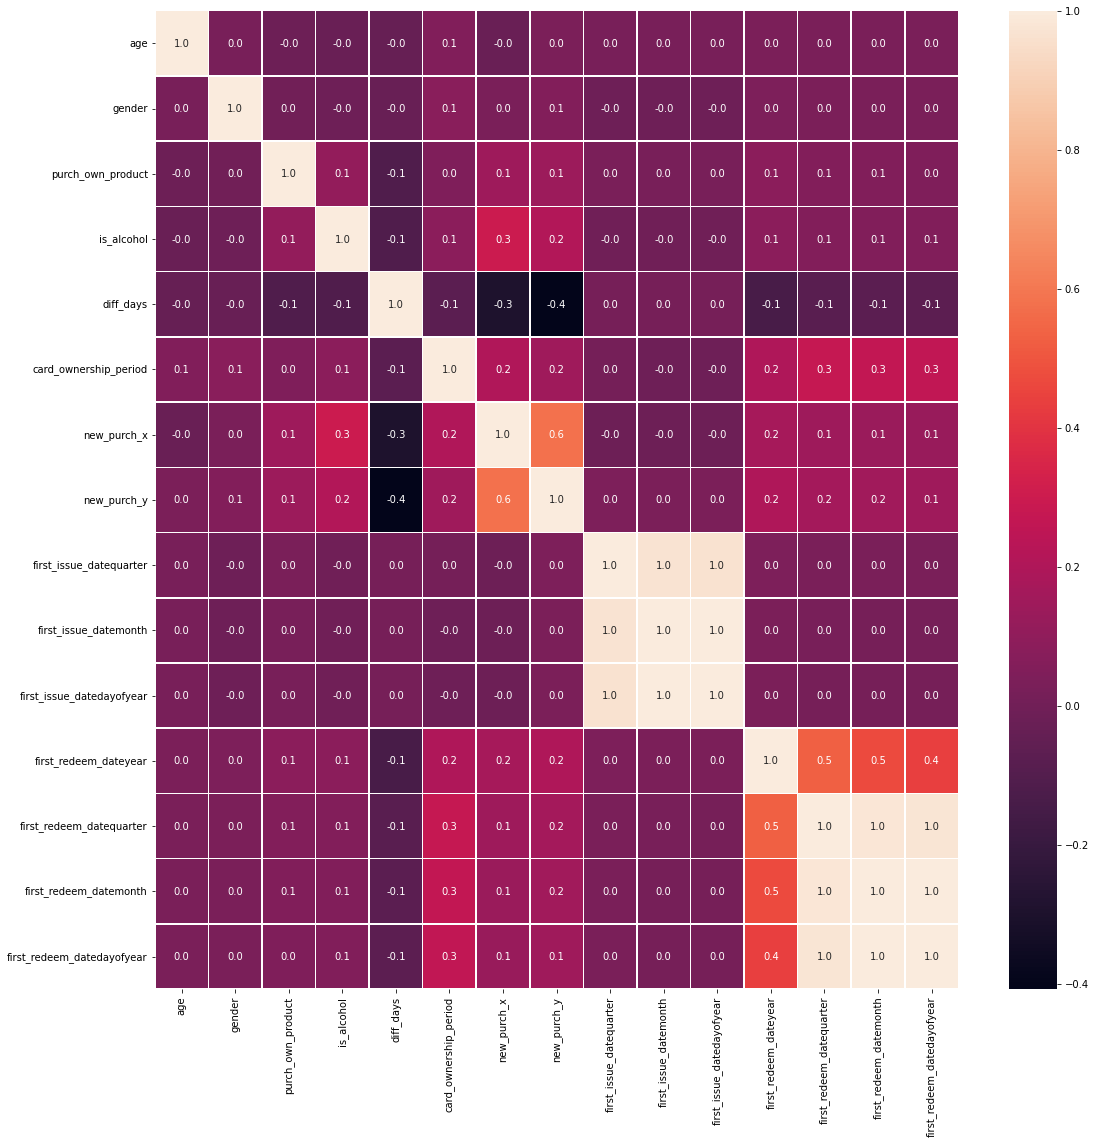

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(clients.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
clients_id_train = train.client_id
clients_id_test = test.client_id

In [ ]:
clients_id_train

0         ad6561e2d8
1         7c1ccbf93f
2         b58fadcab6
3         e99e6fabb9
4         27fb6f8520
             ...    
140022    999d284453
140023    f634deea4e
140024    16cb4f99b0
140025    23c2b72b2e
140026    1430184499
Name: client_id, Length: 140027, dtype: object

In [ ]:
clients_id_test

0        a9a604ed6e
1        ebd7360016
2        908cd9b8e8
3        dceb8ce861
4        f4f0ac6b06
            ...    
60007    4762fb04c5
60008    533d1516e7
60009    c93b21a707
60010    3fe0668de5
60011    8d1ea24f5e
Name: client_id, Length: 60012, dtype: object

In [ ]:
clients_test = clients

In [ ]:
test

,client_id
0,a9a604ed6e
1,ebd7360016
2,908cd9b8e8
3,dceb8ce861
4,f4f0ac6b06
...,...
60007,4762fb04c5
60008,533d1516e7
60009,c93b21a707
60010,3fe0668de5


In [ ]:
clients_test = pd.merge(test,clients,on="client_id")

In [ ]:
clients_test.dtypes

client_id                      object
client_id.1                    object
age                             int64
gender                          int64
purch_own_product               int64
is_alcohol                      int64
diff_days                     float64
card_ownership_period         float64
new_purch_x                   float64
new_purch_y                     int64
first_issue_datequarter         int64
first_issue_datemonth           int64
first_issue_datedayofyear       int64
first_redeem_dateyear           int64
first_redeem_datequarter        int64
first_redeem_datemonth          int64
first_redeem_datedayofyear      int64
dtype: object

In [ ]:
def create_target(df):
  if (df['treatment_flg'] == 1  and df['purchased'] == 1) or (df['treatment_flg'] == 0  and df['purchased'] == 0):
    df['target'] = 1
  else:
    df['target'] = 0
  return df

In [ ]:
train = train.apply(lambda row : create_target(row), axis=1)

In [ ]:
train

,client_id,treatment_flg,purchased,target
0,ad6561e2d8,1,1,1
1,7c1ccbf93f,1,1,1
2,b58fadcab6,1,1,1
3,e99e6fabb9,0,0,1
4,27fb6f8520,1,1,1
...,...,...,...,...
140022,999d284453,1,1,1
140023,f634deea4e,0,1,0
140024,16cb4f99b0,0,1,0
140025,23c2b72b2e,1,1,1


In [ ]:
# clients_train = pd.merge(train,clients)
# clients_train = clients_train.drop(columns=['treatment_flg','purchased'])

In [ ]:
clients

,client_id,client_id.1,age,gender,purch_own_product,is_alcohol,diff_days,card_ownership_period,new_purch_x,new_purch_y,first_issue_datequarter,first_issue_datemonth,first_issue_datedayofyear,first_redeem_dateyear,first_redeem_datequarter,first_redeem_datemonth,first_redeem_datedayofyear
0,000012768d,0,45,0,1,0,4.0,586.0,2803.000000,4,3,8,217,2018,1,1,4
1,000036f903,0,72,2,1,1,1.0,706.0,9805.000000,32,2,4,100,2017,2,4,113
2,00010925a5,0,83,0,1,1,10.0,227.0,5866.000000,18,3,7,205,2018,3,9,257
3,0001f552b0,0,33,2,1,0,2.0,624.0,6155.125000,15,2,6,181,2018,3,8,240
4,00020e7b18,0,73,0,1,0,3.0,473.0,25226.250000,18,4,11,331,2018,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,fffe0abb97,0,35,2,1,0,3.0,473.0,2690.250000,9,4,11,331,2018,1,2,42
200035,fffe0ed719,0,69,0,1,0,0.0,549.0,10417.625000,30,3,9,258,2017,4,12,346
200036,fffea1204c,0,73,2,0,0,5.0,406.0,4257.296875,17,1,1,31,2018,1,3,71
200037,fffeca6d22,0,77,2,1,0,3.0,442.0,2832.875000,16,4,12,362,0,0,0,0


In [ ]:
clients_train = pd.merge(clients,train,on='client_id')

In [ ]:
clients_train=clients_train.drop(columns=['purchased','treatment_flg'])

In [ ]:
train[train['client_id']=='000012768d']

,client_id,treatment_flg,purchased,target
131753,000012768d,0,1,0


In [ ]:
clients_train

,client_id,client_id.1,age,gender,purch_own_product,is_alcohol,diff_days,card_ownership_period,new_purch_x,new_purch_y,first_issue_datequarter,first_issue_datemonth,first_issue_datedayofyear,first_redeem_dateyear,first_redeem_datequarter,first_redeem_datemonth,first_redeem_datedayofyear,target
0,000012768d,0,45,0,1,0,4.0,586.0,2803.000,4,3,8,217,2018,1,1,4,0
1,000036f903,0,72,2,1,1,1.0,706.0,9805.000,32,2,4,100,2017,2,4,113,1
2,0001f552b0,0,33,2,1,0,2.0,624.0,6155.125,15,2,6,181,2018,3,8,240,1
3,00020e7b18,0,73,0,1,0,3.0,473.0,25226.250,18,4,11,331,2018,1,1,10,1
4,000220a0a7,0,115,1,1,1,6.0,458.0,8606.750,15,4,12,343,2018,4,10,277,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140022,fffd5cd0c6,0,47,1,1,0,0.0,630.0,5731.500,18,2,6,177,2018,3,9,266,1
140023,fffd63dfe3,0,31,0,1,1,5.0,656.0,1340.500,4,2,5,146,2018,1,2,47,1
140024,fffd8c9d7d,0,48,2,1,0,10.0,381.0,1636.500,5,1,2,51,2018,2,6,181,0
140025,fffe0abb97,0,35,2,1,0,3.0,473.0,2690.250,9,4,11,331,2018,1,2,42,1


In [ ]:
clients_train = clients_train.drop(columns=['client_id','client_id.1'])

In [ ]:
X_train,y_train = get_x_y(clients_train,'target')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

In [ ]:
X_model = pd.concat([X_train, X_val,X_test], ignore_index=True)
y_model = pd.concat([y_train, y_val,y_test], ignore_index=True)

In [ ]:
collect_features = collect_feature(X_train,object)

In [ ]:
collect_features

[]

In [ ]:
X_train.dtypes

age                             int64
gender                          int64
purch_own_product               int64
is_alcohol                      int64
diff_days                     float64
card_ownership_period         float64
new_purch_x                   float64
new_purch_y                     int64
first_issue_datequarter         int64
first_issue_datemonth           int64
first_issue_datedayofyear       int64
first_redeem_dateyear           int64
first_redeem_datequarter        int64
first_redeem_datemonth          int64
first_redeem_datedayofyear      int64
dtype: object

In [ ]:
X_train.shape

(98018, 15)

In [ ]:
# X_train[['rand_int']] = np.random.randint(10000,size=(140027,1))
# X_train[['rand_float']] = np.random.random(size=(140027,1))
# X_train[['rand_bin']] = np.random.randint(2,size=(140027,1))

In [ ]:
del cocnat_df

In [ ]:
cat = lgbm.LGBMClassifier()
cat.fit(X_model, y_model,verbose=False)

LGBMClassifier()

Text(0.5, 1.0, 'Feature Importance')

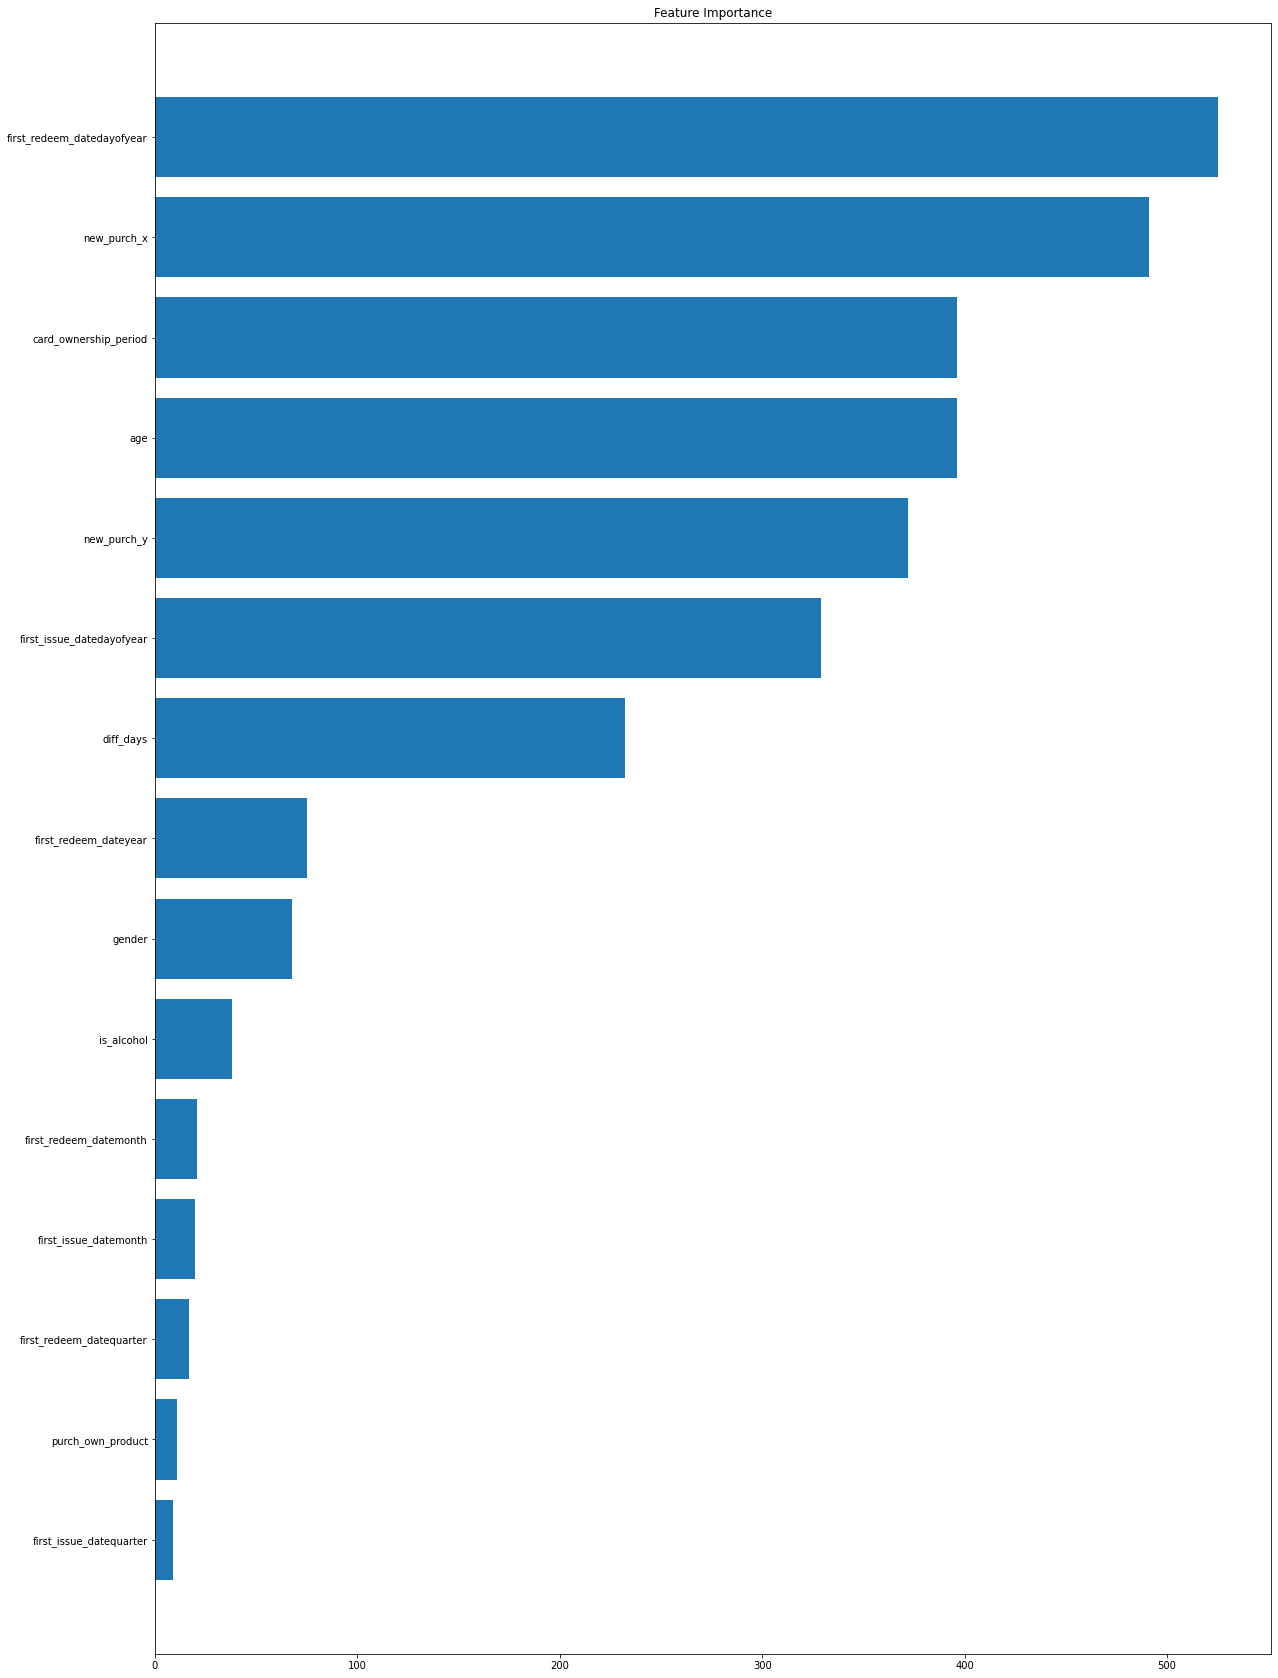

In [ ]:
feature_importance = cat.feature_importances_
feature_importance1 = feature_importance
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
# X_train1, X_cv, y_train1, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state = 0)

In [ ]:
# clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
# models, predictions = clf.fit(X_train1, X_cv, y_train1, y_cv)
# models

In [ ]:
def objective_catboost(trial, X, y):
    params_grid = {
        'iterations':trial.suggest_int("iterations", 1000, 10000),
        'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'od_wait':trial.suggest_int('od_wait', 500, 2000),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'reg_lambda': trial.suggest_int("reg_lambda", 0, 100, step=5),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1,15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose': 200,
        # 'task_type' : 'GPU',
        # 'devices' : '1:3',
        'eval_metric': 'AUC',
        'cat_features':list(collect_features)
    }
    
    if params_grid['bootstrap_type'] == 'Bayesian':
        params_grid['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params_grid['bootstrap_type'] == 'Bernoulli':
        params_grid['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

    cv_scores = np.empty(5)
    accuracy_score_1 = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print('--'*10+f'TRIAL {trial.number} ~ '+f'FOLD {idx}'+'--'*10)
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(**params_grid)
        model.fit(
            X_train, y_train,
            eval_set=[(X_test,y_test)],
            early_stopping_rounds=100,
            use_best_model=True
            
        )
        preds = model.predict(X_test)
        # cv_scores[idx] = log_loss(y_test, preds)
        # print(preds)
        # print()
        # fpr, tpr, thresholds = metrics.roc_curve(y_test.tolist(), preds, pos_label=1)
        accuracy_score_1[idx] = accuracy_score(y_test, preds)
        # print(cv_scores[idx])

    return np.mean(accuracy_score_1)

In [ ]:
def obj(trial, X, y):
    
    params = {
        'leaf_size': trial.suggest_categorical('leaf_size',[5,10,15,20,25,30,35,40,45]),
        'n_neighbors': trial.suggest_categorical('n_neighbors',[3,4,5,6,7,8,9,10]),
        'algorithm': trial.suggest_categorical('algorithm',['auto','ball_tree','kd_tree','brute']),
        "weights": trial.suggest_categorical("weights", ['uniform','distance'])
    } 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

    cv_scores = np.empty(5)
    accuracy_score_1 = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print('--'*10+f'TRIAL {trial.number} ~ '+f'FOLD {idx}'+'--'*10)
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model =  KNeighborsClassifier(**params)
        model.fit(
            X_train, y_train,
            # eval_set=[(X_test,y_test)],
            # early_stopping_rounds=100,
            # use_best_model=True
            
        )
        preds = model.predict(X_test)
        # cv_scores[idx] = log_loss(y_test, preds)
        # print(preds)
        # print()
        # fpr, tpr, thresholds = metrics.roc_curve(y_test.tolist(), preds, pos_label=1)
        accuracy_score_1[idx] = accuracy_score(y_test, preds)
        # print(cv_scores[idx])

    return np.mean(accuracy_score_1)

In [ ]:
# LGBM
from optuna.integration import LightGBMPruningCallback

def objective_lgbm(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        # "gpu_device_id": trial.suggest_int("gpu_device_id", 3,3),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.25),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "max_bin": trial.suggest_int("max_bin", 100, 1000),
        # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1,
        
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

    cv_scores = np.empty(5)
    cv_scores_auc = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print('--'*10+f'TRIAL {trial.number} ~ '+f'FOLD {idx}'+'--'*10)
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="AUC",
            early_stopping_rounds=200,
            verbose= 200,
        )
        preds = model.predict_proba(X_test)
        cv_scores_auc[idx] = roc_auc_score(y_test, preds[:, 1])
        
    print(np.mean(cv_scores_auc))
    return np.mean(cv_scores_auc)

In [ ]:
import sqlite3

In [ ]:
from optuna.storages import RetryFailedTrialCallback

storage = optuna.storages.RDBStorage(
    url="sqlite:////content/drive/MyDrive/Тестовое_ШИФТ/optuna_study_lgbm_03_01.db",
    heartbeat_interval=10,
    grace_period=120,
    failed_trial_callback=RetryFailedTrialCallback(max_retry=3),
)

<ipython-input-143-27f500c3e20f>:7: ExperimentalWarning:

RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.



In [ ]:
optuna_paranms = {
    'direction': "maximize",
    'study_name': "lgbm_01_200_max_bin_min_child_sample",
    'storage':storage
}

In [ ]:
study_catboost = optuna.create_study(**optuna_paranms)
func = lambda trial: objective_lgbm(trial, X_model, y_model)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_catboost.optimize(func, n_trials=200)

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 0 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515063	valid_0's binary_logloss: 0.692383
Early stopping, best iteration is:
[13]	valid_0's auc: 0.517157	valid_0's binary_logloss: 0.692707
--------------------TRIAL 0 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518898	valid_0's binary_logloss: 0.692513
Early stopping, best iteration is:
[30]	valid_0's auc: 0.519268	valid_0's binary_logloss: 0.69265
--------------------TRIAL 0 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513875	valid_0's binary_logloss: 0.692442
Early stopping, best iteration is:
[3]	valid_0's auc: 0.515247	valid_0's binary_logloss: 0.69251
--------------------TRIAL 0 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.512598	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 1 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.693146
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.693146
--------------------TRIAL 1 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515983	valid_0's binary_logloss: 0.692213
Early stopping, best iteration is:
[4]	valid_0's auc: 0.517338	valid_0's binary_logloss: 0.692346
--------------------TRIAL 1 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514588	valid_0's binary_logloss: 0.692195
Early stopping, best iteration is:
[2]	valid_0's auc: 0.515588	valid_0's binary_logloss: 0.692357
--------------------TRIAL 1 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513531	valid_0's b

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 2 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.511458	valid_0's binary_logloss: 0.692137
Early stopping, best iteration is:
[58]	valid_0's auc: 0.513605	valid_0's binary_logloss: 0.692185
--------------------TRIAL 2 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523195	valid_0's binary_logloss: 0.691928
Early stopping, best iteration is:
[63]	valid_0's auc: 0.523371	valid_0's binary_logloss: 0.691975
--------------------TRIAL 2 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514577	valid_0's binary_logloss: 0.6922
Early stopping, best iteration is:
[36]	valid_0's auc: 0.514642	valid_0's binary_logloss: 0.692201
--------------------TRIAL 2 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513998	

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 3 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514442	valid_0's binary_logloss: 0.692181
Early stopping, best iteration is:
[3]	valid_0's auc: 0.514442	valid_0's binary_logloss: 0.692181
--------------------TRIAL 3 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515606	valid_0's binary_logloss: 0.692348
Early stopping, best iteration is:
[6]	valid_0's auc: 0.515606	valid_0's binary_logloss: 0.692348
--------------------TRIAL 3 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514632	valid_0's binary_logloss: 0.692167
Early stopping, best iteration is:
[1]	valid_0's auc: 0.515606	valid_0's binary_logloss: 0.692333
--------------------TRIAL 3 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514607	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 4 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517917	valid_0's binary_logloss: 0.692116
Early stopping, best iteration is:
[8]	valid_0's auc: 0.517917	valid_0's binary_logloss: 0.692116
--------------------TRIAL 4 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519682	valid_0's binary_logloss: 0.69207
Early stopping, best iteration is:
[8]	valid_0's auc: 0.519853	valid_0's binary_logloss: 0.692098
--------------------TRIAL 4 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513705	valid_0's binary_logloss: 0.69215
Early stopping, best iteration is:
[1]	valid_0's auc: 0.516923	valid_0's binary_logloss: 0.692418
--------------------TRIAL 4 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513647	val

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 5 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.511424	valid_0's binary_logloss: 0.692525
Early stopping, best iteration is:
[3]	valid_0's auc: 0.51149	valid_0's binary_logloss: 0.692537
--------------------TRIAL 5 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.693146
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.693146
--------------------TRIAL 5 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.511926	valid_0's binary_logloss: 0.692513
Early stopping, best iteration is:
[10]	valid_0's auc: 0.511926	valid_0's binary_logloss: 0.692513
--------------------TRIAL 5 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.511477	valid_0's b

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 6 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514175	valid_0's binary_logloss: 0.691164
[400]	valid_0's auc: 0.514714	valid_0's binary_logloss: 0.690848
Early stopping, best iteration is:
[310]	valid_0's auc: 0.514988	valid_0's binary_logloss: 0.690839
--------------------TRIAL 6 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524633	valid_0's binary_logloss: 0.690503
[400]	valid_0's auc: 0.524465	valid_0's binary_logloss: 0.690099
Early stopping, best iteration is:
[259]	valid_0's auc: 0.525489	valid_0's binary_logloss: 0.690263
--------------------TRIAL 6 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517722	valid_0's binary_logloss: 0.690981
Early stopping, best iteration is:
[179]	valid_0's auc: 0.518869	valid_0's binary_logloss: 0.69099
----------------

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 7 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520092	valid_0's binary_logloss: 0.689936
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525213	valid_0's binary_logloss: 0.69102
--------------------TRIAL 7 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524394	valid_0's binary_logloss: 0.689677
Early stopping, best iteration is:
[20]	valid_0's auc: 0.526351	valid_0's binary_logloss: 0.690059
--------------------TRIAL 7 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519534	valid_0's binary_logloss: 0.690262
Early stopping, best iteration is:
[3]	valid_0's auc: 0.523204	valid_0's binary_logloss: 0.691616
--------------------TRIAL 7 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519602	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 8 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.50822	valid_0's binary_logloss: 0.692446
Early stopping, best iteration is:
[6]	valid_0's auc: 0.50822	valid_0's binary_logloss: 0.692446
--------------------TRIAL 8 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.510802	valid_0's binary_logloss: 0.692454
Early stopping, best iteration is:
[4]	valid_0's auc: 0.510802	valid_0's binary_logloss: 0.692454
--------------------TRIAL 8 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.511935	valid_0's binary_logloss: 0.69236
Early stopping, best iteration is:
[5]	valid_0's auc: 0.513326	valid_0's binary_logloss: 0.692389
--------------------TRIAL 8 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.512702	vali

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 9 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515809	valid_0's binary_logloss: 0.690711
Early stopping, best iteration is:
[10]	valid_0's auc: 0.517747	valid_0's binary_logloss: 0.691935
--------------------TRIAL 9 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526262	valid_0's binary_logloss: 0.690116
Early stopping, best iteration is:
[124]	valid_0's auc: 0.527111	valid_0's binary_logloss: 0.690417
--------------------TRIAL 9 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520435	valid_0's binary_logloss: 0.690589
Early stopping, best iteration is:
[4]	valid_0's auc: 0.522354	valid_0's binary_logloss: 0.692185
--------------------TRIAL 9 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51969

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 10 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521996	valid_0's binary_logloss: 0.690291
Early stopping, best iteration is:
[3]	valid_0's auc: 0.52378	valid_0's binary_logloss: 0.691644
--------------------TRIAL 10 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522052	valid_0's binary_logloss: 0.690766
Early stopping, best iteration is:
[8]	valid_0's auc: 0.523316	valid_0's binary_logloss: 0.691185
--------------------TRIAL 10 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517474	valid_0's binary_logloss: 0.690938
Early stopping, best iteration is:
[3]	valid_0's auc: 0.522185	valid_0's binary_logloss: 0.691626
--------------------TRIAL 10 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51494

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 11 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523873	valid_0's binary_logloss: 0.6903
Early stopping, best iteration is:
[17]	valid_0's auc: 0.525327	valid_0's binary_logloss: 0.69056
--------------------TRIAL 11 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522867	valid_0's binary_logloss: 0.69041
Early stopping, best iteration is:
[25]	valid_0's auc: 0.524108	valid_0's binary_logloss: 0.690623
--------------------TRIAL 11 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518311	valid_0's binary_logloss: 0.690904
Early stopping, best iteration is:
[3]	valid_0's auc: 0.522404	valid_0's binary_logloss: 0.691683
--------------------TRIAL 11 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515606

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 12 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517668	valid_0's binary_logloss: 0.692019
Early stopping, best iteration is:
[8]	valid_0's auc: 0.517704	valid_0's binary_logloss: 0.692236
--------------------TRIAL 12 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51082	valid_0's binary_logloss: 0.692055
Early stopping, best iteration is:
[2]	valid_0's auc: 0.51082	valid_0's binary_logloss: 0.692055
--------------------TRIAL 12 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5143	valid_0's binary_logloss: 0.691617
Early stopping, best iteration is:
[4]	valid_0's auc: 0.516164	valid_0's binary_logloss: 0.691634
--------------------TRIAL 12 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517824	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 13 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522113	valid_0's binary_logloss: 0.69064
Early stopping, best iteration is:
[6]	valid_0's auc: 0.522827	valid_0's binary_logloss: 0.691319
--------------------TRIAL 13 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52437	valid_0's binary_logloss: 0.690378
Early stopping, best iteration is:
[5]	valid_0's auc: 0.527627	valid_0's binary_logloss: 0.691452
--------------------TRIAL 13 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516189	valid_0's binary_logloss: 0.690641
Early stopping, best iteration is:
[2]	valid_0's auc: 0.520359	valid_0's binary_logloss: 0.69188
--------------------TRIAL 13 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51919	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 14 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523847	valid_0's binary_logloss: 0.689415
Early stopping, best iteration is:
[10]	valid_0's auc: 0.5246	valid_0's binary_logloss: 0.68972
--------------------TRIAL 14 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525349	valid_0's binary_logloss: 0.689406
Early stopping, best iteration is:
[14]	valid_0's auc: 0.525583	valid_0's binary_logloss: 0.689426
--------------------TRIAL 14 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518209	valid_0's binary_logloss: 0.689762
Early stopping, best iteration is:
[6]	valid_0's auc: 0.519943	valid_0's binary_logloss: 0.690253
--------------------TRIAL 14 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51968

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 15 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520887	valid_0's binary_logloss: 0.689667
Early stopping, best iteration is:
[9]	valid_0's auc: 0.522503	valid_0's binary_logloss: 0.690147
--------------------TRIAL 15 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525631	valid_0's binary_logloss: 0.689569
Early stopping, best iteration is:
[15]	valid_0's auc: 0.526073	valid_0's binary_logloss: 0.69009
--------------------TRIAL 15 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519117	valid_0's binary_logloss: 0.690194
Early stopping, best iteration is:
[6]	valid_0's auc: 0.5203	valid_0's binary_logloss: 0.690777
--------------------TRIAL 15 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519277

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 16 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517444	valid_0's binary_logloss: 0.690756
Early stopping, best iteration is:
[9]	valid_0's auc: 0.517468	valid_0's binary_logloss: 0.69077
--------------------TRIAL 16 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521006	valid_0's binary_logloss: 0.69095
Early stopping, best iteration is:
[9]	valid_0's auc: 0.521006	valid_0's binary_logloss: 0.69095
--------------------TRIAL 16 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51509	valid_0's binary_logloss: 0.690699
Early stopping, best iteration is:
[6]	valid_0's auc: 0.516427	valid_0's binary_logloss: 0.690973
--------------------TRIAL 16 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515072	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 17 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521195	valid_0's binary_logloss: 0.689745
Early stopping, best iteration is:
[3]	valid_0's auc: 0.525472	valid_0's binary_logloss: 0.690836
--------------------TRIAL 17 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525105	valid_0's binary_logloss: 0.689691
Early stopping, best iteration is:
[3]	valid_0's auc: 0.525948	valid_0's binary_logloss: 0.690794
--------------------TRIAL 17 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51789	valid_0's binary_logloss: 0.690358
Early stopping, best iteration is:
[7]	valid_0's auc: 0.519643	valid_0's binary_logloss: 0.690634
--------------------TRIAL 17 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52214

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 18 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51681	valid_0's binary_logloss: 0.691315
Early stopping, best iteration is:
[57]	valid_0's auc: 0.522944	valid_0's binary_logloss: 0.690082
--------------------TRIAL 18 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518049	valid_0's binary_logloss: 0.690865
Early stopping, best iteration is:
[16]	valid_0's auc: 0.52464	valid_0's binary_logloss: 0.690347
--------------------TRIAL 18 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514051	valid_0's binary_logloss: 0.691927
Early stopping, best iteration is:
[13]	valid_0's auc: 0.521642	valid_0's binary_logloss: 0.690489
--------------------TRIAL 18 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 19 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515736	valid_0's binary_logloss: 0.69202
Early stopping, best iteration is:
[5]	valid_0's auc: 0.515736	valid_0's binary_logloss: 0.69202
--------------------TRIAL 19 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515999	valid_0's binary_logloss: 0.692154
Early stopping, best iteration is:
[6]	valid_0's auc: 0.515999	valid_0's binary_logloss: 0.692154
--------------------TRIAL 19 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514458	valid_0's binary_logloss: 0.692038
Early stopping, best iteration is:
[1]	valid_0's auc: 0.515281	valid_0's binary_logloss: 0.692286
--------------------TRIAL 19 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515561

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 20 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519681	valid_0's binary_logloss: 0.689772
Early stopping, best iteration is:
[12]	valid_0's auc: 0.524461	valid_0's binary_logloss: 0.690108
--------------------TRIAL 20 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52388	valid_0's binary_logloss: 0.689456
Early stopping, best iteration is:
[19]	valid_0's auc: 0.526767	valid_0's binary_logloss: 0.689544
--------------------TRIAL 20 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520497	valid_0's binary_logloss: 0.690003
Early stopping, best iteration is:
[1]	valid_0's auc: 0.522575	valid_0's binary_logloss: 0.691998
--------------------TRIAL 20 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 21 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521892	valid_0's binary_logloss: 0.689577
Early stopping, best iteration is:
[3]	valid_0's auc: 0.526097	valid_0's binary_logloss: 0.691411
--------------------TRIAL 21 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526884	valid_0's binary_logloss: 0.689372
Early stopping, best iteration is:
[18]	valid_0's auc: 0.526958	valid_0's binary_logloss: 0.689636
--------------------TRIAL 21 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519555	valid_0's binary_logloss: 0.690142
Early stopping, best iteration is:
[9]	valid_0's auc: 0.521363	valid_0's binary_logloss: 0.690433
--------------------TRIAL 21 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 22 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519831	valid_0's binary_logloss: 0.690613
Early stopping, best iteration is:
[8]	valid_0's auc: 0.521145	valid_0's binary_logloss: 0.691371
--------------------TRIAL 22 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521516	valid_0's binary_logloss: 0.690903
Early stopping, best iteration is:
[17]	valid_0's auc: 0.521516	valid_0's binary_logloss: 0.690903
--------------------TRIAL 22 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516435	valid_0's binary_logloss: 0.691074
Early stopping, best iteration is:
[7]	valid_0's auc: 0.519956	valid_0's binary_logloss: 0.691358
--------------------TRIAL 22 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 23 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523589	valid_0's binary_logloss: 0.689518
Early stopping, best iteration is:
[7]	valid_0's auc: 0.526763	valid_0's binary_logloss: 0.69025
--------------------TRIAL 23 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526791	valid_0's binary_logloss: 0.689524
Early stopping, best iteration is:
[20]	valid_0's auc: 0.526791	valid_0's binary_logloss: 0.689524
--------------------TRIAL 23 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517775	valid_0's binary_logloss: 0.690163
Early stopping, best iteration is:
[11]	valid_0's auc: 0.519269	valid_0's binary_logloss: 0.690714
--------------------TRIAL 23 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 24 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524811	valid_0's binary_logloss: 0.689504
Early stopping, best iteration is:
[6]	valid_0's auc: 0.527236	valid_0's binary_logloss: 0.690914
--------------------TRIAL 24 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526641	valid_0's binary_logloss: 0.68917
Early stopping, best iteration is:
[20]	valid_0's auc: 0.527973	valid_0's binary_logloss: 0.689758
--------------------TRIAL 24 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517123	valid_0's binary_logloss: 0.689883
Early stopping, best iteration is:
[5]	valid_0's auc: 0.519348	valid_0's binary_logloss: 0.691335
--------------------TRIAL 24 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5217

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 25 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523335	valid_0's binary_logloss: 0.690938
Early stopping, best iteration is:
[6]	valid_0's auc: 0.526469	valid_0's binary_logloss: 0.691211
--------------------TRIAL 25 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521319	valid_0's binary_logloss: 0.690853
Early stopping, best iteration is:
[9]	valid_0's auc: 0.523631	valid_0's binary_logloss: 0.691147
--------------------TRIAL 25 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516991	valid_0's binary_logloss: 0.690907
Early stopping, best iteration is:
[1]	valid_0's auc: 0.519395	valid_0's binary_logloss: 0.692127
--------------------TRIAL 25 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5204

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 26 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519823	valid_0's binary_logloss: 0.690424
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520082	valid_0's binary_logloss: 0.690963
--------------------TRIAL 26 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524854	valid_0's binary_logloss: 0.690627
Early stopping, best iteration is:
[20]	valid_0's auc: 0.524875	valid_0's binary_logloss: 0.690638
--------------------TRIAL 26 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517344	valid_0's binary_logloss: 0.691174
Early stopping, best iteration is:
[11]	valid_0's auc: 0.518492	valid_0's binary_logloss: 0.691191
--------------------TRIAL 26 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 27 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.509165	valid_0's binary_logloss: 0.692733
Early stopping, best iteration is:
[6]	valid_0's auc: 0.509165	valid_0's binary_logloss: 0.692733
--------------------TRIAL 27 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.693146
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.693146
--------------------TRIAL 27 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514207	valid_0's binary_logloss: 0.692265
Early stopping, best iteration is:
[5]	valid_0's auc: 0.516291	valid_0's binary_logloss: 0.692342
--------------------TRIAL 27 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.511846	valid_0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 28 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515549	valid_0's binary_logloss: 0.690875
Early stopping, best iteration is:
[7]	valid_0's auc: 0.519691	valid_0's binary_logloss: 0.691998
--------------------TRIAL 28 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525318	valid_0's binary_logloss: 0.690647
Early stopping, best iteration is:
[47]	valid_0's auc: 0.525822	valid_0's binary_logloss: 0.690644
--------------------TRIAL 28 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516915	valid_0's binary_logloss: 0.690888
Early stopping, best iteration is:
[2]	valid_0's auc: 0.52037	valid_0's binary_logloss: 0.692217
--------------------TRIAL 28 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5190

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 29 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520545	valid_0's binary_logloss: 0.691675
Early stopping, best iteration is:
[9]	valid_0's auc: 0.523255	valid_0's binary_logloss: 0.692047
--------------------TRIAL 29 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523541	valid_0's binary_logloss: 0.691572
Early stopping, best iteration is:
[18]	valid_0's auc: 0.524102	valid_0's binary_logloss: 0.691823
--------------------TRIAL 29 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518727	valid_0's binary_logloss: 0.691454
Early stopping, best iteration is:
[30]	valid_0's auc: 0.519514	valid_0's binary_logloss: 0.691598
--------------------TRIAL 29 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 30 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522941	valid_0's binary_logloss: 0.690277
Early stopping, best iteration is:
[8]	valid_0's auc: 0.524539	valid_0's binary_logloss: 0.691063
--------------------TRIAL 30 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522955	valid_0's binary_logloss: 0.690565
Early stopping, best iteration is:
[20]	valid_0's auc: 0.522955	valid_0's binary_logloss: 0.690565
--------------------TRIAL 30 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51667	valid_0's binary_logloss: 0.690898
Early stopping, best iteration is:
[3]	valid_0's auc: 0.519144	valid_0's binary_logloss: 0.691744
--------------------TRIAL 30 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5189

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 31 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521644	valid_0's binary_logloss: 0.689555
Early stopping, best iteration is:
[8]	valid_0's auc: 0.525734	valid_0's binary_logloss: 0.690016
--------------------TRIAL 31 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524187	valid_0's binary_logloss: 0.68931
Early stopping, best iteration is:
[8]	valid_0's auc: 0.52523	valid_0's binary_logloss: 0.69012
--------------------TRIAL 31 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515616	valid_0's binary_logloss: 0.690198
Early stopping, best iteration is:
[4]	valid_0's auc: 0.521644	valid_0's binary_logloss: 0.69094
--------------------TRIAL 31 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523235	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 32 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522613	valid_0's binary_logloss: 0.689312
Early stopping, best iteration is:
[7]	valid_0's auc: 0.527797	valid_0's binary_logloss: 0.689534
--------------------TRIAL 32 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522561	valid_0's binary_logloss: 0.689008
Early stopping, best iteration is:
[8]	valid_0's auc: 0.523784	valid_0's binary_logloss: 0.689501
--------------------TRIAL 32 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519084	valid_0's binary_logloss: 0.689844
Early stopping, best iteration is:
[17]	valid_0's auc: 0.519185	valid_0's binary_logloss: 0.689794
--------------------TRIAL 32 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 33 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525892	valid_0's binary_logloss: 0.689578
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526875	valid_0's binary_logloss: 0.690402
--------------------TRIAL 33 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524619	valid_0's binary_logloss: 0.68987
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526073	valid_0's binary_logloss: 0.690727
--------------------TRIAL 33 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519864	valid_0's binary_logloss: 0.689975
Early stopping, best iteration is:
[17]	valid_0's auc: 0.520745	valid_0's binary_logloss: 0.689942
--------------------TRIAL 33 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5217

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 34 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519539	valid_0's binary_logloss: 0.690001
Early stopping, best iteration is:
[3]	valid_0's auc: 0.525668	valid_0's binary_logloss: 0.691156
--------------------TRIAL 34 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519862	valid_0's binary_logloss: 0.689678
Early stopping, best iteration is:
[17]	valid_0's auc: 0.526946	valid_0's binary_logloss: 0.689697
--------------------TRIAL 34 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519514	valid_0's binary_logloss: 0.690089
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520654	valid_0's binary_logloss: 0.690374
--------------------TRIAL 34 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 35 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521042	valid_0's binary_logloss: 0.689432
Early stopping, best iteration is:
[6]	valid_0's auc: 0.526431	valid_0's binary_logloss: 0.690432
--------------------TRIAL 35 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520903	valid_0's binary_logloss: 0.689189
Early stopping, best iteration is:
[14]	valid_0's auc: 0.526873	valid_0's binary_logloss: 0.689997
--------------------TRIAL 35 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520389	valid_0's binary_logloss: 0.689872
Early stopping, best iteration is:
[8]	valid_0's auc: 0.52169	valid_0's binary_logloss: 0.690454
--------------------TRIAL 35 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5214

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 36 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522998	valid_0's binary_logloss: 0.689004
Early stopping, best iteration is:
[6]	valid_0's auc: 0.526324	valid_0's binary_logloss: 0.690243
--------------------TRIAL 36 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525645	valid_0's binary_logloss: 0.68875
Early stopping, best iteration is:
[15]	valid_0's auc: 0.526984	valid_0's binary_logloss: 0.68976
--------------------TRIAL 36 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518913	valid_0's binary_logloss: 0.689659
Early stopping, best iteration is:
[27]	valid_0's auc: 0.519499	valid_0's binary_logloss: 0.689695
--------------------TRIAL 36 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5209

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 37 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521793	valid_0's binary_logloss: 0.688921
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525389	valid_0's binary_logloss: 0.690553
--------------------TRIAL 37 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527157	valid_0's binary_logloss: 0.688507
Early stopping, best iteration is:
[18]	valid_0's auc: 0.528828	valid_0's binary_logloss: 0.689315
--------------------TRIAL 37 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518943	valid_0's binary_logloss: 0.689378
Early stopping, best iteration is:
[7]	valid_0's auc: 0.520347	valid_0's binary_logloss: 0.690685
--------------------TRIAL 37 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 38 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52179	valid_0's binary_logloss: 0.689682
Early stopping, best iteration is:
[6]	valid_0's auc: 0.523781	valid_0's binary_logloss: 0.691099
--------------------TRIAL 38 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526214	valid_0's binary_logloss: 0.689393
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526884	valid_0's binary_logloss: 0.6915
--------------------TRIAL 38 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518859	valid_0's binary_logloss: 0.68996
Early stopping, best iteration is:
[25]	valid_0's auc: 0.519548	valid_0's binary_logloss: 0.690358
--------------------TRIAL 38 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521223	

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 39 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516172	valid_0's binary_logloss: 0.691993
Early stopping, best iteration is:
[19]	valid_0's auc: 0.516172	valid_0's binary_logloss: 0.691993
--------------------TRIAL 39 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522404	valid_0's binary_logloss: 0.691709
Early stopping, best iteration is:
[8]	valid_0's auc: 0.522678	valid_0's binary_logloss: 0.691932
--------------------TRIAL 39 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513496	valid_0's binary_logloss: 0.691898
Early stopping, best iteration is:
[4]	valid_0's auc: 0.513838	valid_0's binary_logloss: 0.692068
--------------------TRIAL 39 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 40 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515577	valid_0's binary_logloss: 0.692076
Early stopping, best iteration is:
[10]	valid_0's auc: 0.515647	valid_0's binary_logloss: 0.692094
--------------------TRIAL 40 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515375	valid_0's binary_logloss: 0.691911
Early stopping, best iteration is:
[5]	valid_0's auc: 0.517114	valid_0's binary_logloss: 0.692138
--------------------TRIAL 40 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516398	valid_0's binary_logloss: 0.691793
Early stopping, best iteration is:
[5]	valid_0's auc: 0.517317	valid_0's binary_logloss: 0.691971
--------------------TRIAL 40 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 41 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522291	valid_0's binary_logloss: 0.689366
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525772	valid_0's binary_logloss: 0.690354
--------------------TRIAL 41 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526744	valid_0's binary_logloss: 0.689233
Early stopping, best iteration is:
[27]	valid_0's auc: 0.526744	valid_0's binary_logloss: 0.689233
--------------------TRIAL 41 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517725	valid_0's binary_logloss: 0.690057
Early stopping, best iteration is:
[4]	valid_0's auc: 0.51929	valid_0's binary_logloss: 0.691279
--------------------TRIAL 41 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5195

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 42 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524105	valid_0's binary_logloss: 0.68931
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525578	valid_0's binary_logloss: 0.690925
--------------------TRIAL 42 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526395	valid_0's binary_logloss: 0.689025
Early stopping, best iteration is:
[42]	valid_0's auc: 0.526916	valid_0's binary_logloss: 0.689251
--------------------TRIAL 42 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519711	valid_0's binary_logloss: 0.689836
Early stopping, best iteration is:
[7]	valid_0's auc: 0.520772	valid_0's binary_logloss: 0.690678
--------------------TRIAL 42 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5221

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 43 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522829	valid_0's binary_logloss: 0.689741
Early stopping, best iteration is:
[5]	valid_0's auc: 0.525428	valid_0's binary_logloss: 0.690907
--------------------TRIAL 43 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522529	valid_0's binary_logloss: 0.689621
Early stopping, best iteration is:
[8]	valid_0's auc: 0.523047	valid_0's binary_logloss: 0.690809
--------------------TRIAL 43 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518802	valid_0's binary_logloss: 0.690016
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520189	valid_0's binary_logloss: 0.690628
--------------------TRIAL 43 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5209

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 44 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521589	valid_0's binary_logloss: 0.690284
Early stopping, best iteration is:
[32]	valid_0's auc: 0.522008	valid_0's binary_logloss: 0.690328
--------------------TRIAL 44 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522592	valid_0's binary_logloss: 0.690369
Early stopping, best iteration is:
[22]	valid_0's auc: 0.522775	valid_0's binary_logloss: 0.690581
--------------------TRIAL 44 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518742	valid_0's binary_logloss: 0.690677
Early stopping, best iteration is:
[5]	valid_0's auc: 0.520156	valid_0's binary_logloss: 0.691459
--------------------TRIAL 44 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 45 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515665	valid_0's binary_logloss: 0.691795
Early stopping, best iteration is:
[3]	valid_0's auc: 0.515665	valid_0's binary_logloss: 0.691795
--------------------TRIAL 45 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517083	valid_0's binary_logloss: 0.692505
Early stopping, best iteration is:
[4]	valid_0's auc: 0.517083	valid_0's binary_logloss: 0.692505
--------------------TRIAL 45 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514455	valid_0's binary_logloss: 0.692146
Early stopping, best iteration is:
[3]	valid_0's auc: 0.514455	valid_0's binary_logloss: 0.692146
--------------------TRIAL 45 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5123

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 46 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51902	valid_0's binary_logloss: 0.690823
Early stopping, best iteration is:
[10]	valid_0's auc: 0.519619	valid_0's binary_logloss: 0.690957
--------------------TRIAL 46 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524073	valid_0's binary_logloss: 0.690365
Early stopping, best iteration is:
[16]	valid_0's auc: 0.524337	valid_0's binary_logloss: 0.690372
--------------------TRIAL 46 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517057	valid_0's binary_logloss: 0.690458
Early stopping, best iteration is:
[4]	valid_0's auc: 0.518937	valid_0's binary_logloss: 0.691434
--------------------TRIAL 46 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 47 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52013	valid_0's binary_logloss: 0.689572
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526982	valid_0's binary_logloss: 0.690638
--------------------TRIAL 47 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523501	valid_0's binary_logloss: 0.689197
Early stopping, best iteration is:
[25]	valid_0's auc: 0.528947	valid_0's binary_logloss: 0.689898
--------------------TRIAL 47 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519152	valid_0's binary_logloss: 0.689798
Early stopping, best iteration is:
[35]	valid_0's auc: 0.520955	valid_0's binary_logloss: 0.689985
--------------------TRIAL 47 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 48 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517516	valid_0's binary_logloss: 0.692107
Early stopping, best iteration is:
[5]	valid_0's auc: 0.517898	valid_0's binary_logloss: 0.692135
--------------------TRIAL 48 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520739	valid_0's binary_logloss: 0.692194
Early stopping, best iteration is:
[7]	valid_0's auc: 0.520739	valid_0's binary_logloss: 0.692194
--------------------TRIAL 48 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.512596	valid_0's binary_logloss: 0.692128
Early stopping, best iteration is:
[1]	valid_0's auc: 0.517007	valid_0's binary_logloss: 0.692399
--------------------TRIAL 48 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5154

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 49 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521328	valid_0's binary_logloss: 0.690647
Early stopping, best iteration is:
[5]	valid_0's auc: 0.5244	valid_0's binary_logloss: 0.691685
--------------------TRIAL 49 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521613	valid_0's binary_logloss: 0.690628
Early stopping, best iteration is:
[4]	valid_0's auc: 0.5245	valid_0's binary_logloss: 0.691702
--------------------TRIAL 49 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516046	valid_0's binary_logloss: 0.690831
Early stopping, best iteration is:
[3]	valid_0's auc: 0.519722	valid_0's binary_logloss: 0.691884
--------------------TRIAL 49 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516519	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 50 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520467	valid_0's binary_logloss: 0.690971
Early stopping, best iteration is:
[14]	valid_0's auc: 0.521003	valid_0's binary_logloss: 0.691085
--------------------TRIAL 50 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521628	valid_0's binary_logloss: 0.69141
Early stopping, best iteration is:
[10]	valid_0's auc: 0.521928	valid_0's binary_logloss: 0.691476
--------------------TRIAL 50 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516312	valid_0's binary_logloss: 0.691477
Early stopping, best iteration is:
[6]	valid_0's auc: 0.518377	valid_0's binary_logloss: 0.691553
--------------------TRIAL 50 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 51 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522973	valid_0's binary_logloss: 0.68959
Early stopping, best iteration is:
[4]	valid_0's auc: 0.524382	valid_0's binary_logloss: 0.691118
--------------------TRIAL 51 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526678	valid_0's binary_logloss: 0.689407
Early stopping, best iteration is:
[13]	valid_0's auc: 0.527026	valid_0's binary_logloss: 0.690239
--------------------TRIAL 51 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516607	valid_0's binary_logloss: 0.690225
Early stopping, best iteration is:
[7]	valid_0's auc: 0.518678	valid_0's binary_logloss: 0.691071
--------------------TRIAL 51 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5205

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 52 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522148	valid_0's binary_logloss: 0.689364
Early stopping, best iteration is:
[21]	valid_0's auc: 0.525101	valid_0's binary_logloss: 0.69
--------------------TRIAL 52 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526559	valid_0's binary_logloss: 0.688922
Early stopping, best iteration is:
[19]	valid_0's auc: 0.527816	valid_0's binary_logloss: 0.690155
--------------------TRIAL 52 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51934	valid_0's binary_logloss: 0.689846
Early stopping, best iteration is:
[9]	valid_0's auc: 0.521055	valid_0's binary_logloss: 0.69101
--------------------TRIAL 52 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520339	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 53 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523048	valid_0's binary_logloss: 0.689971
Early stopping, best iteration is:
[8]	valid_0's auc: 0.523969	valid_0's binary_logloss: 0.691185
--------------------TRIAL 53 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525745	valid_0's binary_logloss: 0.690184
Early stopping, best iteration is:
[10]	valid_0's auc: 0.526204	valid_0's binary_logloss: 0.690888
--------------------TRIAL 53 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51918	valid_0's binary_logloss: 0.690221
Early stopping, best iteration is:
[4]	valid_0's auc: 0.521207	valid_0's binary_logloss: 0.691472
--------------------TRIAL 53 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5208

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 54 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522942	valid_0's binary_logloss: 0.689896
Early stopping, best iteration is:
[8]	valid_0's auc: 0.523643	valid_0's binary_logloss: 0.690257
--------------------TRIAL 54 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525242	valid_0's binary_logloss: 0.690164
Early stopping, best iteration is:
[13]	valid_0's auc: 0.525612	valid_0's binary_logloss: 0.690177
--------------------TRIAL 54 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517482	valid_0's binary_logloss: 0.690076
Early stopping, best iteration is:
[6]	valid_0's auc: 0.518402	valid_0's binary_logloss: 0.690466
--------------------TRIAL 54 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 55 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522896	valid_0's binary_logloss: 0.689523
Early stopping, best iteration is:
[24]	valid_0's auc: 0.524225	valid_0's binary_logloss: 0.690101
--------------------TRIAL 55 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526364	valid_0's binary_logloss: 0.689471
Early stopping, best iteration is:
[17]	valid_0's auc: 0.527229	valid_0's binary_logloss: 0.690565
--------------------TRIAL 55 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518468	valid_0's binary_logloss: 0.69025
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520982	valid_0's binary_logloss: 0.691296
--------------------TRIAL 55 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 56 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518672	valid_0's binary_logloss: 0.690781
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520221	valid_0's binary_logloss: 0.691693
--------------------TRIAL 56 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522374	valid_0's binary_logloss: 0.69093
Early stopping, best iteration is:
[11]	valid_0's auc: 0.523493	valid_0's binary_logloss: 0.69152
--------------------TRIAL 56 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516541	valid_0's binary_logloss: 0.690989
Early stopping, best iteration is:
[36]	valid_0's auc: 0.517301	valid_0's binary_logloss: 0.691133
--------------------TRIAL 56 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5159

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 57 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.510713	valid_0's binary_logloss: 0.69184
Early stopping, best iteration is:
[45]	valid_0's auc: 0.511643	valid_0's binary_logloss: 0.691964
--------------------TRIAL 57 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520935	valid_0's binary_logloss: 0.691875
Early stopping, best iteration is:
[17]	valid_0's auc: 0.520935	valid_0's binary_logloss: 0.691875
--------------------TRIAL 57 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516502	valid_0's binary_logloss: 0.691885
Early stopping, best iteration is:
[7]	valid_0's auc: 0.51824	valid_0's binary_logloss: 0.692189
--------------------TRIAL 57 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5148

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 58 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520964	valid_0's binary_logloss: 0.690601
Early stopping, best iteration is:
[9]	valid_0's auc: 0.520964	valid_0's binary_logloss: 0.690601
--------------------TRIAL 58 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520225	valid_0's binary_logloss: 0.691399
Early stopping, best iteration is:
[9]	valid_0's auc: 0.520225	valid_0's binary_logloss: 0.691399
--------------------TRIAL 58 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515714	valid_0's binary_logloss: 0.690935
Early stopping, best iteration is:
[5]	valid_0's auc: 0.518442	valid_0's binary_logloss: 0.690929
--------------------TRIAL 58 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5168

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 59 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520738	valid_0's binary_logloss: 0.69065
Early stopping, best iteration is:
[10]	valid_0's auc: 0.522307	valid_0's binary_logloss: 0.690968
--------------------TRIAL 59 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525817	valid_0's binary_logloss: 0.690345
Early stopping, best iteration is:
[16]	valid_0's auc: 0.526611	valid_0's binary_logloss: 0.690375
--------------------TRIAL 59 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516769	valid_0's binary_logloss: 0.69069
Early stopping, best iteration is:
[4]	valid_0's auc: 0.51803	valid_0's binary_logloss: 0.691698
--------------------TRIAL 59 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51852

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 60 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522741	valid_0's binary_logloss: 0.690934
Early stopping, best iteration is:
[13]	valid_0's auc: 0.522741	valid_0's binary_logloss: 0.690934
--------------------TRIAL 60 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524759	valid_0's binary_logloss: 0.690445
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525957	valid_0's binary_logloss: 0.691028
--------------------TRIAL 60 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517663	valid_0's binary_logloss: 0.690617
Early stopping, best iteration is:
[10]	valid_0's auc: 0.518254	valid_0's binary_logloss: 0.691167
--------------------TRIAL 60 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 61 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520379	valid_0's binary_logloss: 0.689019
Early stopping, best iteration is:
[6]	valid_0's auc: 0.527118	valid_0's binary_logloss: 0.690249
--------------------TRIAL 61 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526585	valid_0's binary_logloss: 0.688442
Early stopping, best iteration is:
[18]	valid_0's auc: 0.528606	valid_0's binary_logloss: 0.689293
--------------------TRIAL 61 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51837	valid_0's binary_logloss: 0.689283
Early stopping, best iteration is:
[7]	valid_0's auc: 0.520663	valid_0's binary_logloss: 0.690852
--------------------TRIAL 61 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5210

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 62 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521808	valid_0's binary_logloss: 0.689664
Early stopping, best iteration is:
[34]	valid_0's auc: 0.522389	valid_0's binary_logloss: 0.689707
--------------------TRIAL 62 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526698	valid_0's binary_logloss: 0.68941
Early stopping, best iteration is:
[30]	valid_0's auc: 0.526911	valid_0's binary_logloss: 0.689634
--------------------TRIAL 62 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519215	valid_0's binary_logloss: 0.690052
Early stopping, best iteration is:
[27]	valid_0's auc: 0.519686	valid_0's binary_logloss: 0.690145
--------------------TRIAL 62 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 63 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52208	valid_0's binary_logloss: 0.690218
Early stopping, best iteration is:
[18]	valid_0's auc: 0.52208	valid_0's binary_logloss: 0.690245
--------------------TRIAL 63 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523273	valid_0's binary_logloss: 0.690037
Early stopping, best iteration is:
[26]	valid_0's auc: 0.523547	valid_0's binary_logloss: 0.690143
--------------------TRIAL 63 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517221	valid_0's binary_logloss: 0.690814
Early stopping, best iteration is:
[4]	valid_0's auc: 0.51919	valid_0's binary_logloss: 0.691707
--------------------TRIAL 63 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51814

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 64 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520972	valid_0's binary_logloss: 0.689543
Early stopping, best iteration is:
[4]	valid_0's auc: 0.523437	valid_0's binary_logloss: 0.690864
--------------------TRIAL 64 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526443	valid_0's binary_logloss: 0.689044
Early stopping, best iteration is:
[6]	valid_0's auc: 0.527278	valid_0's binary_logloss: 0.690445
--------------------TRIAL 64 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517845	valid_0's binary_logloss: 0.68995
Early stopping, best iteration is:
[5]	valid_0's auc: 0.519946	valid_0's binary_logloss: 0.691032
--------------------TRIAL 64 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52096

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 65 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518375	valid_0's binary_logloss: 0.690276
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520345	valid_0's binary_logloss: 0.690476
--------------------TRIAL 65 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523992	valid_0's binary_logloss: 0.690721
Early stopping, best iteration is:
[3]	valid_0's auc: 0.524543	valid_0's binary_logloss: 0.691339
--------------------TRIAL 65 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518366	valid_0's binary_logloss: 0.69002
Early stopping, best iteration is:
[6]	valid_0's auc: 0.518586	valid_0's binary_logloss: 0.690397
--------------------TRIAL 65 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519	v

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 66 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523932	valid_0's binary_logloss: 0.689508
Early stopping, best iteration is:
[6]	valid_0's auc: 0.52638	valid_0's binary_logloss: 0.690592
--------------------TRIAL 66 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527423	valid_0's binary_logloss: 0.68948
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527598	valid_0's binary_logloss: 0.689569
--------------------TRIAL 66 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518861	valid_0's binary_logloss: 0.690134
Early stopping, best iteration is:
[7]	valid_0's auc: 0.519914	valid_0's binary_logloss: 0.69086
--------------------TRIAL 66 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520012

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 67 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523701	valid_0's binary_logloss: 0.68994
Early stopping, best iteration is:
[9]	valid_0's auc: 0.525875	valid_0's binary_logloss: 0.690415
--------------------TRIAL 67 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525479	valid_0's binary_logloss: 0.689995
Early stopping, best iteration is:
[19]	valid_0's auc: 0.525479	valid_0's binary_logloss: 0.689995
--------------------TRIAL 67 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518859	valid_0's binary_logloss: 0.690229
Early stopping, best iteration is:
[1]	valid_0's auc: 0.519957	valid_0's binary_logloss: 0.69198
--------------------TRIAL 67 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52077

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 68 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520568	valid_0's binary_logloss: 0.690173
Early stopping, best iteration is:
[6]	valid_0's auc: 0.522285	valid_0's binary_logloss: 0.69107
--------------------TRIAL 68 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523497	valid_0's binary_logloss: 0.689953
Early stopping, best iteration is:
[25]	valid_0's auc: 0.523711	valid_0's binary_logloss: 0.689997
--------------------TRIAL 68 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518656	valid_0's binary_logloss: 0.690295
Early stopping, best iteration is:
[9]	valid_0's auc: 0.521166	valid_0's binary_logloss: 0.691046
--------------------TRIAL 68 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5207

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 69 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523734	valid_0's binary_logloss: 0.68946
Early stopping, best iteration is:
[3]	valid_0's auc: 0.525298	valid_0's binary_logloss: 0.691604
--------------------TRIAL 69 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525529	valid_0's binary_logloss: 0.689442
Early stopping, best iteration is:
[15]	valid_0's auc: 0.526859	valid_0's binary_logloss: 0.690177
--------------------TRIAL 69 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516804	valid_0's binary_logloss: 0.690225
Early stopping, best iteration is:
[8]	valid_0's auc: 0.518382	valid_0's binary_logloss: 0.690937
--------------------TRIAL 69 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5215

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 70 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514076	valid_0's binary_logloss: 0.692278
Early stopping, best iteration is:
[21]	valid_0's auc: 0.514596	valid_0's binary_logloss: 0.692322
--------------------TRIAL 70 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523049	valid_0's binary_logloss: 0.691383
Early stopping, best iteration is:
[181]	valid_0's auc: 0.523665	valid_0's binary_logloss: 0.691412
--------------------TRIAL 70 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516657	valid_0's binary_logloss: 0.691686
[400]	valid_0's auc: 0.517286	valid_0's binary_logloss: 0.691459
[600]	valid_0's auc: 0.517647	valid_0's binary_logloss: 0.69139
Early stopping, best iteration is:
[453]	valid_0's auc: 0.517702	valid_0's binary_logloss: 0.691387
--------------

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 71 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523356	valid_0's binary_logloss: 0.689179
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525683	valid_0's binary_logloss: 0.690386
--------------------TRIAL 71 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526494	valid_0's binary_logloss: 0.68903
Early stopping, best iteration is:
[17]	valid_0's auc: 0.52769	valid_0's binary_logloss: 0.689491
--------------------TRIAL 71 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518769	valid_0's binary_logloss: 0.68983
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521262	valid_0's binary_logloss: 0.690489
--------------------TRIAL 71 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521817

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 72 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521899	valid_0's binary_logloss: 0.68913
Early stopping, best iteration is:
[9]	valid_0's auc: 0.525786	valid_0's binary_logloss: 0.690216
--------------------TRIAL 72 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526631	valid_0's binary_logloss: 0.68887
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527335	valid_0's binary_logloss: 0.689246
--------------------TRIAL 72 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518597	valid_0's binary_logloss: 0.689867
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521267	valid_0's binary_logloss: 0.690507
--------------------TRIAL 72 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52103

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 73 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52363	valid_0's binary_logloss: 0.689194
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525258	valid_0's binary_logloss: 0.69041
--------------------TRIAL 73 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526799	valid_0's binary_logloss: 0.689068
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527373	valid_0's binary_logloss: 0.689349
--------------------TRIAL 73 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520132	valid_0's binary_logloss: 0.689678
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521582	valid_0's binary_logloss: 0.690494
--------------------TRIAL 73 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52102

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 74 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521098	valid_0's binary_logloss: 0.689257
Early stopping, best iteration is:
[7]	valid_0's auc: 0.522789	valid_0's binary_logloss: 0.690699
--------------------TRIAL 74 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524579	valid_0's binary_logloss: 0.689057
Early stopping, best iteration is:
[26]	valid_0's auc: 0.525164	valid_0's binary_logloss: 0.689459
--------------------TRIAL 74 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520112	valid_0's binary_logloss: 0.689758
Early stopping, best iteration is:
[27]	valid_0's auc: 0.521024	valid_0's binary_logloss: 0.689971
--------------------TRIAL 74 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 75 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523645	valid_0's binary_logloss: 0.68926
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525389	valid_0's binary_logloss: 0.69049
--------------------TRIAL 75 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.528067	valid_0's binary_logloss: 0.689029
Early stopping, best iteration is:
[18]	valid_0's auc: 0.528285	valid_0's binary_logloss: 0.689098
--------------------TRIAL 75 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51898	valid_0's binary_logloss: 0.689752
Early stopping, best iteration is:
[6]	valid_0's auc: 0.520146	valid_0's binary_logloss: 0.69042
--------------------TRIAL 75 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521555	

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 76 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524194	valid_0's binary_logloss: 0.689531
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526093	valid_0's binary_logloss: 0.690036
--------------------TRIAL 76 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526213	valid_0's binary_logloss: 0.68969
Early stopping, best iteration is:
[13]	valid_0's auc: 0.526454	valid_0's binary_logloss: 0.69014
--------------------TRIAL 76 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519832	valid_0's binary_logloss: 0.68989
Early stopping, best iteration is:
[21]	valid_0's auc: 0.520041	valid_0's binary_logloss: 0.689994
--------------------TRIAL 76 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52051

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 77 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524197	valid_0's binary_logloss: 0.68907
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525591	valid_0's binary_logloss: 0.690212
--------------------TRIAL 77 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527974	valid_0's binary_logloss: 0.688867
Early stopping, best iteration is:
[23]	valid_0's auc: 0.52819	valid_0's binary_logloss: 0.689051
--------------------TRIAL 77 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518004	valid_0's binary_logloss: 0.689581
Early stopping, best iteration is:
[6]	valid_0's auc: 0.519902	valid_0's binary_logloss: 0.69017
--------------------TRIAL 77 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521784

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 78 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520303	valid_0's binary_logloss: 0.689948
Early stopping, best iteration is:
[17]	valid_0's auc: 0.520563	valid_0's binary_logloss: 0.689946
--------------------TRIAL 78 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526252	valid_0's binary_logloss: 0.689373
Early stopping, best iteration is:
[16]	valid_0's auc: 0.527246	valid_0's binary_logloss: 0.689979
--------------------TRIAL 78 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519762	valid_0's binary_logloss: 0.690048
Early stopping, best iteration is:
[19]	valid_0's auc: 0.520182	valid_0's binary_logloss: 0.690029
--------------------TRIAL 78 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 79 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523934	valid_0's binary_logloss: 0.689246
Early stopping, best iteration is:
[6]	valid_0's auc: 0.52522	valid_0's binary_logloss: 0.690497
--------------------TRIAL 79 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526877	valid_0's binary_logloss: 0.688947
Early stopping, best iteration is:
[25]	valid_0's auc: 0.528182	valid_0's binary_logloss: 0.688983
--------------------TRIAL 79 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519695	valid_0's binary_logloss: 0.689527
Early stopping, best iteration is:
[8]	valid_0's auc: 0.521577	valid_0's binary_logloss: 0.690246
--------------------TRIAL 79 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5216

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 80 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521676	valid_0's binary_logloss: 0.68941
Early stopping, best iteration is:
[7]	valid_0's auc: 0.522409	valid_0's binary_logloss: 0.690476
--------------------TRIAL 80 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525743	valid_0's binary_logloss: 0.689113
Early stopping, best iteration is:
[26]	valid_0's auc: 0.525835	valid_0's binary_logloss: 0.689131
--------------------TRIAL 80 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51968	valid_0's binary_logloss: 0.68987
Early stopping, best iteration is:
[18]	valid_0's auc: 0.521294	valid_0's binary_logloss: 0.68995
--------------------TRIAL 80 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52015	

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 81 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523747	valid_0's binary_logloss: 0.689136
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525329	valid_0's binary_logloss: 0.690454
--------------------TRIAL 81 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.529897	valid_0's binary_logloss: 0.689025
Early stopping, best iteration is:
[23]	valid_0's auc: 0.529946	valid_0's binary_logloss: 0.689035
--------------------TRIAL 81 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519093	valid_0's binary_logloss: 0.689554
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521153	valid_0's binary_logloss: 0.690332
--------------------TRIAL 81 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 82 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523702	valid_0's binary_logloss: 0.689152
Early stopping, best iteration is:
[6]	valid_0's auc: 0.524848	valid_0's binary_logloss: 0.690534
--------------------TRIAL 82 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525754	valid_0's binary_logloss: 0.688931
Early stopping, best iteration is:
[11]	valid_0's auc: 0.527067	valid_0's binary_logloss: 0.689645
--------------------TRIAL 82 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518944	valid_0's binary_logloss: 0.689681
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521723	valid_0's binary_logloss: 0.690279
--------------------TRIAL 82 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 83 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519825	valid_0's binary_logloss: 0.689988
Early stopping, best iteration is:
[5]	valid_0's auc: 0.520056	valid_0's binary_logloss: 0.691207
--------------------TRIAL 83 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524915	valid_0's binary_logloss: 0.689419
Early stopping, best iteration is:
[26]	valid_0's auc: 0.526857	valid_0's binary_logloss: 0.689631
--------------------TRIAL 83 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517483	valid_0's binary_logloss: 0.690038
Early stopping, best iteration is:
[23]	valid_0's auc: 0.51797	valid_0's binary_logloss: 0.690264
--------------------TRIAL 83 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 84 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52163	valid_0's binary_logloss: 0.689865
Early stopping, best iteration is:
[8]	valid_0's auc: 0.523366	valid_0's binary_logloss: 0.690689
--------------------TRIAL 84 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524384	valid_0's binary_logloss: 0.68985
Early stopping, best iteration is:
[6]	valid_0's auc: 0.524783	valid_0's binary_logloss: 0.690441
--------------------TRIAL 84 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518244	valid_0's binary_logloss: 0.690288
Early stopping, best iteration is:
[4]	valid_0's auc: 0.51863	valid_0's binary_logloss: 0.691141
--------------------TRIAL 84 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522332	

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 85 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519422	valid_0's binary_logloss: 0.691037
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520122	valid_0's binary_logloss: 0.691052
--------------------TRIAL 85 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525235	valid_0's binary_logloss: 0.690924
Early stopping, best iteration is:
[8]	valid_0's auc: 0.525258	valid_0's binary_logloss: 0.691351
--------------------TRIAL 85 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515872	valid_0's binary_logloss: 0.690849
Early stopping, best iteration is:
[4]	valid_0's auc: 0.518092	valid_0's binary_logloss: 0.691235
--------------------TRIAL 85 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5169

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 86 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.511581	valid_0's binary_logloss: 0.691877
Early stopping, best iteration is:
[1]	valid_0's auc: 0.513505	valid_0's binary_logloss: 0.692458
--------------------TRIAL 86 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52237	valid_0's binary_logloss: 0.691635
Early stopping, best iteration is:
[24]	valid_0's auc: 0.522758	valid_0's binary_logloss: 0.691741
--------------------TRIAL 86 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515411	valid_0's binary_logloss: 0.691748
Early stopping, best iteration is:
[43]	valid_0's auc: 0.515715	valid_0's binary_logloss: 0.691792
--------------------TRIAL 86 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 87 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522728	valid_0's binary_logloss: 0.689382
Early stopping, best iteration is:
[11]	valid_0's auc: 0.524447	valid_0's binary_logloss: 0.690022
--------------------TRIAL 87 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525624	valid_0's binary_logloss: 0.689071
Early stopping, best iteration is:
[21]	valid_0's auc: 0.527553	valid_0's binary_logloss: 0.689199
--------------------TRIAL 87 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520051	valid_0's binary_logloss: 0.68954
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520618	valid_0's binary_logloss: 0.690414
--------------------TRIAL 87 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 88 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523429	valid_0's binary_logloss: 0.689357
Early stopping, best iteration is:
[9]	valid_0's auc: 0.524551	valid_0's binary_logloss: 0.690312
--------------------TRIAL 88 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525499	valid_0's binary_logloss: 0.689368
Early stopping, best iteration is:
[21]	valid_0's auc: 0.52626	valid_0's binary_logloss: 0.68937
--------------------TRIAL 88 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518525	valid_0's binary_logloss: 0.689763
Early stopping, best iteration is:
[14]	valid_0's auc: 0.519098	valid_0's binary_logloss: 0.690171
--------------------TRIAL 88 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5211

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 89 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522244	valid_0's binary_logloss: 0.689544
Early stopping, best iteration is:
[19]	valid_0's auc: 0.522744	valid_0's binary_logloss: 0.689622
--------------------TRIAL 89 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526173	valid_0's binary_logloss: 0.689291
Early stopping, best iteration is:
[17]	valid_0's auc: 0.527035	valid_0's binary_logloss: 0.689631
--------------------TRIAL 89 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517713	valid_0's binary_logloss: 0.689868
Early stopping, best iteration is:
[4]	valid_0's auc: 0.521167	valid_0's binary_logloss: 0.691246
--------------------TRIAL 89 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 90 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520518	valid_0's binary_logloss: 0.690677
Early stopping, best iteration is:
[15]	valid_0's auc: 0.520518	valid_0's binary_logloss: 0.690677
--------------------TRIAL 90 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522901	valid_0's binary_logloss: 0.690766
Early stopping, best iteration is:
[11]	valid_0's auc: 0.522901	valid_0's binary_logloss: 0.690766
--------------------TRIAL 90 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.512491	valid_0's binary_logloss: 0.69105
Early stopping, best iteration is:
[2]	valid_0's auc: 0.515245	valid_0's binary_logloss: 0.691866
--------------------TRIAL 90 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 91 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523501	valid_0's binary_logloss: 0.688897
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525533	valid_0's binary_logloss: 0.69023
--------------------TRIAL 91 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527055	valid_0's binary_logloss: 0.688875
Early stopping, best iteration is:
[17]	valid_0's auc: 0.527249	valid_0's binary_logloss: 0.689046
--------------------TRIAL 91 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518734	valid_0's binary_logloss: 0.689301
Early stopping, best iteration is:
[8]	valid_0's auc: 0.521234	valid_0's binary_logloss: 0.690072
--------------------TRIAL 91 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5207

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 92 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521967	valid_0's binary_logloss: 0.689264
Early stopping, best iteration is:
[6]	valid_0's auc: 0.524665	valid_0's binary_logloss: 0.690317
--------------------TRIAL 92 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527969	valid_0's binary_logloss: 0.688791
Early stopping, best iteration is:
[25]	valid_0's auc: 0.528163	valid_0's binary_logloss: 0.688956
--------------------TRIAL 92 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519171	valid_0's binary_logloss: 0.689627
Early stopping, best iteration is:
[6]	valid_0's auc: 0.519988	valid_0's binary_logloss: 0.69042
--------------------TRIAL 92 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5219

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 93 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516059	valid_0's binary_logloss: 0.691741
Early stopping, best iteration is:
[8]	valid_0's auc: 0.516059	valid_0's binary_logloss: 0.691741
--------------------TRIAL 93 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519602	valid_0's binary_logloss: 0.691586
Early stopping, best iteration is:
[2]	valid_0's auc: 0.520259	valid_0's binary_logloss: 0.691754
--------------------TRIAL 93 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51356	valid_0's binary_logloss: 0.691082
Early stopping, best iteration is:
[4]	valid_0's auc: 0.51494	valid_0's binary_logloss: 0.691556
--------------------TRIAL 93 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513002

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 94 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522233	valid_0's binary_logloss: 0.689333
Early stopping, best iteration is:
[7]	valid_0's auc: 0.523747	valid_0's binary_logloss: 0.690467
--------------------TRIAL 94 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525741	valid_0's binary_logloss: 0.689506
Early stopping, best iteration is:
[17]	valid_0's auc: 0.526053	valid_0's binary_logloss: 0.689509
--------------------TRIAL 94 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51846	valid_0's binary_logloss: 0.689734
Early stopping, best iteration is:
[4]	valid_0's auc: 0.519004	valid_0's binary_logloss: 0.691254
--------------------TRIAL 94 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5220

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 95 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522566	valid_0's binary_logloss: 0.689938
Early stopping, best iteration is:
[6]	valid_0's auc: 0.52424	valid_0's binary_logloss: 0.691812
--------------------TRIAL 95 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525881	valid_0's binary_logloss: 0.6897
Early stopping, best iteration is:
[67]	valid_0's auc: 0.526108	valid_0's binary_logloss: 0.689792
--------------------TRIAL 95 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519542	valid_0's binary_logloss: 0.690057
Early stopping, best iteration is:
[7]	valid_0's auc: 0.522155	valid_0's binary_logloss: 0.691711
--------------------TRIAL 95 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521014

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 96 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521323	valid_0's binary_logloss: 0.689889
[400]	valid_0's auc: 0.521722	valid_0's binary_logloss: 0.689797
Early stopping, best iteration is:
[220]	valid_0's auc: 0.521921	valid_0's binary_logloss: 0.689793
--------------------TRIAL 96 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526214	valid_0's binary_logloss: 0.689539
Early stopping, best iteration is:
[13]	valid_0's auc: 0.52678	valid_0's binary_logloss: 0.691547
--------------------TRIAL 96 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518061	valid_0's binary_logloss: 0.6904
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521322	valid_0's binary_logloss: 0.691934
--------------------TRIAL 96 ~ FOLD 3--------------------
Training until validation

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 97 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517682	valid_0's binary_logloss: 0.690567
Early stopping, best iteration is:
[3]	valid_0's auc: 0.526623	valid_0's binary_logloss: 0.691073
--------------------TRIAL 97 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520718	valid_0's binary_logloss: 0.690085
Early stopping, best iteration is:
[7]	valid_0's auc: 0.526114	valid_0's binary_logloss: 0.690492
--------------------TRIAL 97 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514158	valid_0's binary_logloss: 0.691151
Early stopping, best iteration is:
[4]	valid_0's auc: 0.521361	valid_0's binary_logloss: 0.690955
--------------------TRIAL 97 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5208

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 98 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519416	valid_0's binary_logloss: 0.690243
Early stopping, best iteration is:
[7]	valid_0's auc: 0.522368	valid_0's binary_logloss: 0.690763
--------------------TRIAL 98 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526225	valid_0's binary_logloss: 0.689919
Early stopping, best iteration is:
[21]	valid_0's auc: 0.52631	valid_0's binary_logloss: 0.690065
--------------------TRIAL 98 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520785	valid_0's binary_logloss: 0.690079
Early stopping, best iteration is:
[19]	valid_0's auc: 0.521399	valid_0's binary_logloss: 0.690214
--------------------TRIAL 98 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 99 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523043	valid_0's binary_logloss: 0.690202
Early stopping, best iteration is:
[11]	valid_0's auc: 0.523118	valid_0's binary_logloss: 0.690558
--------------------TRIAL 99 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522995	valid_0's binary_logloss: 0.690283
Early stopping, best iteration is:
[13]	valid_0's auc: 0.523356	valid_0's binary_logloss: 0.69029
--------------------TRIAL 99 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516349	valid_0's binary_logloss: 0.690404
Early stopping, best iteration is:
[4]	valid_0's auc: 0.517713	valid_0's binary_logloss: 0.691252
--------------------TRIAL 99 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 100 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523224	valid_0's binary_logloss: 0.689383
Early stopping, best iteration is:
[6]	valid_0's auc: 0.527266	valid_0's binary_logloss: 0.69023
--------------------TRIAL 100 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525485	valid_0's binary_logloss: 0.689249
Early stopping, best iteration is:
[14]	valid_0's auc: 0.52646	valid_0's binary_logloss: 0.689881
--------------------TRIAL 100 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520133	valid_0's binary_logloss: 0.689914
Early stopping, best iteration is:
[6]	valid_0's auc: 0.520716	valid_0's binary_logloss: 0.690524
--------------------TRIAL 100 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 101 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522499	valid_0's binary_logloss: 0.689307
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525038	valid_0's binary_logloss: 0.690553
--------------------TRIAL 101 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527899	valid_0's binary_logloss: 0.689116
Early stopping, best iteration is:
[24]	valid_0's auc: 0.528378	valid_0's binary_logloss: 0.689306
--------------------TRIAL 101 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519617	valid_0's binary_logloss: 0.689645
Early stopping, best iteration is:
[6]	valid_0's auc: 0.519996	valid_0's binary_logloss: 0.690487
--------------------TRIAL 101 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 102 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524259	valid_0's binary_logloss: 0.689895
Early stopping, best iteration is:
[8]	valid_0's auc: 0.525959	valid_0's binary_logloss: 0.690203
--------------------TRIAL 102 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524717	valid_0's binary_logloss: 0.689862
Early stopping, best iteration is:
[6]	valid_0's auc: 0.524869	valid_0's binary_logloss: 0.690516
--------------------TRIAL 102 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519503	valid_0's binary_logloss: 0.690254
Early stopping, best iteration is:
[17]	valid_0's auc: 0.519554	valid_0's binary_logloss: 0.690431
--------------------TRIAL 102 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 103 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52361	valid_0's binary_logloss: 0.689208
Early stopping, best iteration is:
[6]	valid_0's auc: 0.52532	valid_0's binary_logloss: 0.690271
--------------------TRIAL 103 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524794	valid_0's binary_logloss: 0.689393
Early stopping, best iteration is:
[5]	valid_0's auc: 0.525362	valid_0's binary_logloss: 0.690967
--------------------TRIAL 103 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517257	valid_0's binary_logloss: 0.689825
Early stopping, best iteration is:
[7]	valid_0's auc: 0.517919	valid_0's binary_logloss: 0.690355
--------------------TRIAL 103 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 104 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522765	valid_0's binary_logloss: 0.689045
Early stopping, best iteration is:
[20]	valid_0's auc: 0.525056	valid_0's binary_logloss: 0.689159
--------------------TRIAL 104 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526097	valid_0's binary_logloss: 0.689095
Early stopping, best iteration is:
[17]	valid_0's auc: 0.526791	valid_0's binary_logloss: 0.689455
--------------------TRIAL 104 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517935	valid_0's binary_logloss: 0.689539
Early stopping, best iteration is:
[7]	valid_0's auc: 0.52049	valid_0's binary_logloss: 0.690043
--------------------TRIAL 104 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 105 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519759	valid_0's binary_logloss: 0.690007
Early stopping, best iteration is:
[9]	valid_0's auc: 0.521957	valid_0's binary_logloss: 0.690867
--------------------TRIAL 105 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524734	valid_0's binary_logloss: 0.690002
Early stopping, best iteration is:
[12]	valid_0's auc: 0.525207	valid_0's binary_logloss: 0.690317
--------------------TRIAL 105 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517867	valid_0's binary_logloss: 0.690116
Early stopping, best iteration is:
[16]	valid_0's auc: 0.518333	valid_0's binary_logloss: 0.690527
--------------------TRIAL 105 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 106 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518113	valid_0's binary_logloss: 0.690157
Early stopping, best iteration is:
[167]	valid_0's auc: 0.518113	valid_0's binary_logloss: 0.690157
--------------------TRIAL 106 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526389	valid_0's binary_logloss: 0.689532
[400]	valid_0's auc: 0.526682	valid_0's binary_logloss: 0.689391
Early stopping, best iteration is:
[232]	valid_0's auc: 0.526971	valid_0's binary_logloss: 0.689389
--------------------TRIAL 106 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519568	valid_0's binary_logloss: 0.690321
Early stopping, best iteration is:
[114]	valid_0's auc: 0.520894	valid_0's binary_logloss: 0.690345
--------------------TRIAL 106 ~ FOLD 3--------------------
Training until 

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 107 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522586	valid_0's binary_logloss: 0.689328
Early stopping, best iteration is:
[19]	valid_0's auc: 0.522586	valid_0's binary_logloss: 0.689328
--------------------TRIAL 107 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524598	valid_0's binary_logloss: 0.689041
Early stopping, best iteration is:
[26]	valid_0's auc: 0.524638	valid_0's binary_logloss: 0.689163
--------------------TRIAL 107 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520627	valid_0's binary_logloss: 0.689485
Early stopping, best iteration is:
[8]	valid_0's auc: 0.522099	valid_0's binary_logloss: 0.689864
--------------------TRIAL 107 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 108 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522902	valid_0's binary_logloss: 0.689059
Early stopping, best iteration is:
[6]	valid_0's auc: 0.527007	valid_0's binary_logloss: 0.69059
--------------------TRIAL 108 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524662	valid_0's binary_logloss: 0.688696
Early stopping, best iteration is:
[24]	valid_0's auc: 0.527948	valid_0's binary_logloss: 0.689191
--------------------TRIAL 108 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518196	valid_0's binary_logloss: 0.689705
Early stopping, best iteration is:
[17]	valid_0's auc: 0.519789	valid_0's binary_logloss: 0.690079
--------------------TRIAL 108 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 109 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522527	valid_0's binary_logloss: 0.689617
Early stopping, best iteration is:
[8]	valid_0's auc: 0.523545	valid_0's binary_logloss: 0.690754
--------------------TRIAL 109 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52574	valid_0's binary_logloss: 0.689777
Early stopping, best iteration is:
[5]	valid_0's auc: 0.525822	valid_0's binary_logloss: 0.691334
--------------------TRIAL 109 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518678	valid_0's binary_logloss: 0.69022
Early stopping, best iteration is:
[4]	valid_0's auc: 0.520945	valid_0's binary_logloss: 0.691578
--------------------TRIAL 109 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 110 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518614	valid_0's binary_logloss: 0.690772
Early stopping, best iteration is:
[9]	valid_0's auc: 0.52085	valid_0's binary_logloss: 0.691958
--------------------TRIAL 110 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524717	valid_0's binary_logloss: 0.690494
Early stopping, best iteration is:
[102]	valid_0's auc: 0.524883	valid_0's binary_logloss: 0.690601
--------------------TRIAL 110 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51788	valid_0's binary_logloss: 0.690866
Early stopping, best iteration is:
[3]	valid_0's auc: 0.51977	valid_0's binary_logloss: 0.692232
--------------------TRIAL 110 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 111 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5237	valid_0's binary_logloss: 0.689353
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525207	valid_0's binary_logloss: 0.690596
--------------------TRIAL 111 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52661	valid_0's binary_logloss: 0.689215
Early stopping, best iteration is:
[17]	valid_0's auc: 0.52725	valid_0's binary_logloss: 0.689507
--------------------TRIAL 111 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518744	valid_0's binary_logloss: 0.689868
Early stopping, best iteration is:
[6]	valid_0's auc: 0.519486	valid_0's binary_logloss: 0.690483
--------------------TRIAL 111 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 112 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522275	valid_0's binary_logloss: 0.689656
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525076	valid_0's binary_logloss: 0.690638
--------------------TRIAL 112 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524703	valid_0's binary_logloss: 0.689775
Early stopping, best iteration is:
[21]	valid_0's auc: 0.525097	valid_0's binary_logloss: 0.689849
--------------------TRIAL 112 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518367	valid_0's binary_logloss: 0.690054
Early stopping, best iteration is:
[8]	valid_0's auc: 0.519222	valid_0's binary_logloss: 0.690791
--------------------TRIAL 112 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 113 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522786	valid_0's binary_logloss: 0.689171
Early stopping, best iteration is:
[11]	valid_0's auc: 0.525072	valid_0's binary_logloss: 0.690498
--------------------TRIAL 113 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526874	valid_0's binary_logloss: 0.689002
Early stopping, best iteration is:
[44]	valid_0's auc: 0.52691	valid_0's binary_logloss: 0.689163
--------------------TRIAL 113 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518944	valid_0's binary_logloss: 0.689795
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521243	valid_0's binary_logloss: 0.690821
--------------------TRIAL 113 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 114 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519907	valid_0's binary_logloss: 0.689599
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525556	valid_0's binary_logloss: 0.690487
--------------------TRIAL 114 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522294	valid_0's binary_logloss: 0.688971
Early stopping, best iteration is:
[15]	valid_0's auc: 0.528112	valid_0's binary_logloss: 0.689682
--------------------TRIAL 114 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517594	valid_0's binary_logloss: 0.690194
Early stopping, best iteration is:
[8]	valid_0's auc: 0.519461	valid_0's binary_logloss: 0.690591
--------------------TRIAL 114 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 115 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523785	valid_0's binary_logloss: 0.689001
Early stopping, best iteration is:
[3]	valid_0's auc: 0.525145	valid_0's binary_logloss: 0.691085
--------------------TRIAL 115 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52572	valid_0's binary_logloss: 0.689159
Early stopping, best iteration is:
[17]	valid_0's auc: 0.526147	valid_0's binary_logloss: 0.689596
--------------------TRIAL 115 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520539	valid_0's binary_logloss: 0.689575
Early stopping, best iteration is:
[5]	valid_0's auc: 0.523038	valid_0's binary_logloss: 0.690633
--------------------TRIAL 115 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 116 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521016	valid_0's binary_logloss: 0.688861
Early stopping, best iteration is:
[22]	valid_0's auc: 0.523075	valid_0's binary_logloss: 0.689115
--------------------TRIAL 116 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525404	valid_0's binary_logloss: 0.688483
Early stopping, best iteration is:
[15]	valid_0's auc: 0.526324	valid_0's binary_logloss: 0.689598
--------------------TRIAL 116 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519561	valid_0's binary_logloss: 0.68915
Early stopping, best iteration is:
[6]	valid_0's auc: 0.52124	valid_0's binary_logloss: 0.690099
--------------------TRIAL 116 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 117 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522123	valid_0's binary_logloss: 0.689245
Early stopping, best iteration is:
[6]	valid_0's auc: 0.522483	valid_0's binary_logloss: 0.690983
--------------------TRIAL 117 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525988	valid_0's binary_logloss: 0.689561
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526161	valid_0's binary_logloss: 0.690967
--------------------TRIAL 117 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519203	valid_0's binary_logloss: 0.689931
Early stopping, best iteration is:
[4]	valid_0's auc: 0.520281	valid_0's binary_logloss: 0.691392
--------------------TRIAL 117 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 118 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523624	valid_0's binary_logloss: 0.689484
Early stopping, best iteration is:
[6]	valid_0's auc: 0.526716	valid_0's binary_logloss: 0.690469
--------------------TRIAL 118 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526743	valid_0's binary_logloss: 0.689356
Early stopping, best iteration is:
[21]	valid_0's auc: 0.527173	valid_0's binary_logloss: 0.689547
--------------------TRIAL 118 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520084	valid_0's binary_logloss: 0.689833
Early stopping, best iteration is:
[5]	valid_0's auc: 0.521045	valid_0's binary_logloss: 0.690771
--------------------TRIAL 118 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 119 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514602	valid_0's binary_logloss: 0.691629
Early stopping, best iteration is:
[4]	valid_0's auc: 0.516121	valid_0's binary_logloss: 0.691621
--------------------TRIAL 119 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519255	valid_0's binary_logloss: 0.691975
Early stopping, best iteration is:
[10]	valid_0's auc: 0.519255	valid_0's binary_logloss: 0.691975
--------------------TRIAL 119 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513203	valid_0's binary_logloss: 0.691589
Early stopping, best iteration is:
[4]	valid_0's auc: 0.514825	valid_0's binary_logloss: 0.691933
--------------------TRIAL 119 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 120 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522686	valid_0's binary_logloss: 0.689666
Early stopping, best iteration is:
[5]	valid_0's auc: 0.525978	valid_0's binary_logloss: 0.690931
--------------------TRIAL 120 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524987	valid_0's binary_logloss: 0.68979
Early stopping, best iteration is:
[16]	valid_0's auc: 0.525151	valid_0's binary_logloss: 0.690145
--------------------TRIAL 120 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517449	valid_0's binary_logloss: 0.690211
Early stopping, best iteration is:
[8]	valid_0's auc: 0.518956	valid_0's binary_logloss: 0.690959
--------------------TRIAL 120 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 121 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523625	valid_0's binary_logloss: 0.689109
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525067	valid_0's binary_logloss: 0.690335
--------------------TRIAL 121 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525949	valid_0's binary_logloss: 0.688781
Early stopping, best iteration is:
[17]	valid_0's auc: 0.527195	valid_0's binary_logloss: 0.689279
--------------------TRIAL 121 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519251	valid_0's binary_logloss: 0.689557
Early stopping, best iteration is:
[6]	valid_0's auc: 0.520349	valid_0's binary_logloss: 0.690234
--------------------TRIAL 121 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 122 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52072	valid_0's binary_logloss: 0.689155
Early stopping, best iteration is:
[8]	valid_0's auc: 0.525857	valid_0's binary_logloss: 0.690177
--------------------TRIAL 122 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52601	valid_0's binary_logloss: 0.688919
Early stopping, best iteration is:
[28]	valid_0's auc: 0.526463	valid_0's binary_logloss: 0.689011
--------------------TRIAL 122 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519211	valid_0's binary_logloss: 0.68936
Early stopping, best iteration is:
[7]	valid_0's auc: 0.522134	valid_0's binary_logloss: 0.690098
--------------------TRIAL 122 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 123 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523775	valid_0's binary_logloss: 0.689505
Early stopping, best iteration is:
[5]	valid_0's auc: 0.525393	valid_0's binary_logloss: 0.690669
--------------------TRIAL 123 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525434	valid_0's binary_logloss: 0.689236
Early stopping, best iteration is:
[15]	valid_0's auc: 0.525847	valid_0's binary_logloss: 0.689757
--------------------TRIAL 123 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51872	valid_0's binary_logloss: 0.690035
Early stopping, best iteration is:
[5]	valid_0's auc: 0.520581	valid_0's binary_logloss: 0.690806
--------------------TRIAL 123 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 124 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522169	valid_0's binary_logloss: 0.689167
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525304	valid_0's binary_logloss: 0.690273
--------------------TRIAL 124 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527755	valid_0's binary_logloss: 0.688968
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527926	valid_0's binary_logloss: 0.689059
--------------------TRIAL 124 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518438	valid_0's binary_logloss: 0.689459
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521037	valid_0's binary_logloss: 0.690156
--------------------TRIAL 124 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 125 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523574	valid_0's binary_logloss: 0.68936
Early stopping, best iteration is:
[4]	valid_0's auc: 0.526265	valid_0's binary_logloss: 0.690556
--------------------TRIAL 125 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522679	valid_0's binary_logloss: 0.689561
Early stopping, best iteration is:
[21]	valid_0's auc: 0.523011	valid_0's binary_logloss: 0.68968
--------------------TRIAL 125 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519249	valid_0's binary_logloss: 0.689863
Early stopping, best iteration is:
[16]	valid_0's auc: 0.519725	valid_0's binary_logloss: 0.690198
--------------------TRIAL 125 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 126 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520236	valid_0's binary_logloss: 0.689019
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526669	valid_0's binary_logloss: 0.68998
--------------------TRIAL 126 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521877	valid_0's binary_logloss: 0.688653
Early stopping, best iteration is:
[17]	valid_0's auc: 0.528506	valid_0's binary_logloss: 0.689163
--------------------TRIAL 126 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519457	valid_0's binary_logloss: 0.689245
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524222	valid_0's binary_logloss: 0.690031
--------------------TRIAL 126 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 127 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521264	valid_0's binary_logloss: 0.690778
Early stopping, best iteration is:
[8]	valid_0's auc: 0.52188	valid_0's binary_logloss: 0.690794
--------------------TRIAL 127 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52276	valid_0's binary_logloss: 0.691293
Early stopping, best iteration is:
[10]	valid_0's auc: 0.522869	valid_0's binary_logloss: 0.691313
--------------------TRIAL 127 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.515016	valid_0's binary_logloss: 0.690647
Early stopping, best iteration is:
[4]	valid_0's auc: 0.517507	valid_0's binary_logloss: 0.691385
--------------------TRIAL 127 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 128 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520202	valid_0's binary_logloss: 0.689193
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525866	valid_0's binary_logloss: 0.690317
--------------------TRIAL 128 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520639	valid_0's binary_logloss: 0.688913
Early stopping, best iteration is:
[11]	valid_0's auc: 0.527988	valid_0's binary_logloss: 0.689778
--------------------TRIAL 128 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518377	valid_0's binary_logloss: 0.689308
Early stopping, best iteration is:
[30]	valid_0's auc: 0.522345	valid_0's binary_logloss: 0.689102
--------------------TRIAL 128 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 129 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518655	valid_0's binary_logloss: 0.689725
Early stopping, best iteration is:
[5]	valid_0's auc: 0.521517	valid_0's binary_logloss: 0.69162
--------------------TRIAL 129 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524536	valid_0's binary_logloss: 0.689445
Early stopping, best iteration is:
[37]	valid_0's auc: 0.524938	valid_0's binary_logloss: 0.689553
--------------------TRIAL 129 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516729	valid_0's binary_logloss: 0.690151
Early stopping, best iteration is:
[4]	valid_0's auc: 0.519453	valid_0's binary_logloss: 0.691811
--------------------TRIAL 129 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 130 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519948	valid_0's binary_logloss: 0.689705
Early stopping, best iteration is:
[2]	valid_0's auc: 0.52186	valid_0's binary_logloss: 0.691645
--------------------TRIAL 130 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526499	valid_0's binary_logloss: 0.689074
Early stopping, best iteration is:
[35]	valid_0's auc: 0.526499	valid_0's binary_logloss: 0.689074
--------------------TRIAL 130 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517716	valid_0's binary_logloss: 0.68983
Early stopping, best iteration is:
[12]	valid_0's auc: 0.520674	valid_0's binary_logloss: 0.69054
--------------------TRIAL 130 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 131 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522484	valid_0's binary_logloss: 0.689219
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526239	valid_0's binary_logloss: 0.690117
--------------------TRIAL 131 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525401	valid_0's binary_logloss: 0.688705
Early stopping, best iteration is:
[19]	valid_0's auc: 0.527845	valid_0's binary_logloss: 0.689516
--------------------TRIAL 131 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519207	valid_0's binary_logloss: 0.689607
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524381	valid_0's binary_logloss: 0.690395
--------------------TRIAL 131 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 132 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524965	valid_0's binary_logloss: 0.689082
Early stopping, best iteration is:
[9]	valid_0's auc: 0.525767	valid_0's binary_logloss: 0.69011
--------------------TRIAL 132 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527254	valid_0's binary_logloss: 0.689019
Early stopping, best iteration is:
[18]	valid_0's auc: 0.527506	valid_0's binary_logloss: 0.689549
--------------------TRIAL 132 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518605	valid_0's binary_logloss: 0.68943
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521862	valid_0's binary_logloss: 0.690351
--------------------TRIAL 132 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 133 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522325	valid_0's binary_logloss: 0.689115
Early stopping, best iteration is:
[9]	valid_0's auc: 0.525904	valid_0's binary_logloss: 0.690018
--------------------TRIAL 133 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526273	valid_0's binary_logloss: 0.689006
Early stopping, best iteration is:
[25]	valid_0's auc: 0.526561	valid_0's binary_logloss: 0.689109
--------------------TRIAL 133 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518774	valid_0's binary_logloss: 0.689762
Early stopping, best iteration is:
[8]	valid_0's auc: 0.521199	valid_0's binary_logloss: 0.690269
--------------------TRIAL 133 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 134 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523425	valid_0's binary_logloss: 0.68933
Early stopping, best iteration is:
[6]	valid_0's auc: 0.5252	valid_0's binary_logloss: 0.690377
--------------------TRIAL 134 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527091	valid_0's binary_logloss: 0.689182
Early stopping, best iteration is:
[24]	valid_0's auc: 0.527203	valid_0's binary_logloss: 0.689321
--------------------TRIAL 134 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51936	valid_0's binary_logloss: 0.689693
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521485	valid_0's binary_logloss: 0.690405
--------------------TRIAL 134 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 135 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521352	valid_0's binary_logloss: 0.689603
Early stopping, best iteration is:
[9]	valid_0's auc: 0.524744	valid_0's binary_logloss: 0.691259
--------------------TRIAL 135 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521809	valid_0's binary_logloss: 0.689396
Early stopping, best iteration is:
[12]	valid_0's auc: 0.52762	valid_0's binary_logloss: 0.6912
--------------------TRIAL 135 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517787	valid_0's binary_logloss: 0.690138
Early stopping, best iteration is:
[2]	valid_0's auc: 0.521394	valid_0's binary_logloss: 0.692015
--------------------TRIAL 135 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 136 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519402	valid_0's binary_logloss: 0.689763
Early stopping, best iteration is:
[76]	valid_0's auc: 0.520351	valid_0's binary_logloss: 0.689771
--------------------TRIAL 136 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526521	valid_0's binary_logloss: 0.689172
Early stopping, best iteration is:
[40]	valid_0's auc: 0.527906	valid_0's binary_logloss: 0.689392
--------------------TRIAL 136 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516951	valid_0's binary_logloss: 0.690167
Early stopping, best iteration is:
[87]	valid_0's auc: 0.516951	valid_0's binary_logloss: 0.690167
--------------------TRIAL 136 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc:

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 137 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52431	valid_0's binary_logloss: 0.689225
Early stopping, best iteration is:
[6]	valid_0's auc: 0.527163	valid_0's binary_logloss: 0.69001
--------------------TRIAL 137 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526146	valid_0's binary_logloss: 0.689228
Early stopping, best iteration is:
[19]	valid_0's auc: 0.526647	valid_0's binary_logloss: 0.68953
--------------------TRIAL 137 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518137	valid_0's binary_logloss: 0.689524
Early stopping, best iteration is:
[6]	valid_0's auc: 0.519915	valid_0's binary_logloss: 0.690267
--------------------TRIAL 137 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 138 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.514025	valid_0's binary_logloss: 0.691869
Early stopping, best iteration is:
[2]	valid_0's auc: 0.514427	valid_0's binary_logloss: 0.691857
--------------------TRIAL 138 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521238	valid_0's binary_logloss: 0.691724
Early stopping, best iteration is:
[5]	valid_0's auc: 0.521774	valid_0's binary_logloss: 0.691763
--------------------TRIAL 138 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.513655	valid_0's binary_logloss: 0.69117
Early stopping, best iteration is:
[3]	valid_0's auc: 0.515116	valid_0's binary_logloss: 0.691991
--------------------TRIAL 138 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 139 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522222	valid_0's binary_logloss: 0.689529
Early stopping, best iteration is:
[6]	valid_0's auc: 0.524778	valid_0's binary_logloss: 0.690409
--------------------TRIAL 139 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525741	valid_0's binary_logloss: 0.689832
Early stopping, best iteration is:
[23]	valid_0's auc: 0.525741	valid_0's binary_logloss: 0.689832
--------------------TRIAL 139 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52034	valid_0's binary_logloss: 0.689836
Early stopping, best iteration is:
[5]	valid_0's auc: 0.520856	valid_0's binary_logloss: 0.690865
--------------------TRIAL 139 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 140 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522617	valid_0's binary_logloss: 0.689312
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525808	valid_0's binary_logloss: 0.690438
--------------------TRIAL 140 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527268	valid_0's binary_logloss: 0.689067
Early stopping, best iteration is:
[21]	valid_0's auc: 0.527569	valid_0's binary_logloss: 0.689209
--------------------TRIAL 140 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517405	valid_0's binary_logloss: 0.689837
Early stopping, best iteration is:
[4]	valid_0's auc: 0.519413	valid_0's binary_logloss: 0.691013
--------------------TRIAL 140 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 141 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524241	valid_0's binary_logloss: 0.688963
Early stopping, best iteration is:
[20]	valid_0's auc: 0.525218	valid_0's binary_logloss: 0.689219
--------------------TRIAL 141 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527016	valid_0's binary_logloss: 0.688892
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527556	valid_0's binary_logloss: 0.689232
--------------------TRIAL 141 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519204	valid_0's binary_logloss: 0.689325
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521415	valid_0's binary_logloss: 0.69003
--------------------TRIAL 141 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 142 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521337	valid_0's binary_logloss: 0.689122
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525797	valid_0's binary_logloss: 0.690218
--------------------TRIAL 142 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526343	valid_0's binary_logloss: 0.688664
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527361	valid_0's binary_logloss: 0.689223
--------------------TRIAL 142 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51927	valid_0's binary_logloss: 0.689252
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521938	valid_0's binary_logloss: 0.690093
--------------------TRIAL 142 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 143 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522899	valid_0's binary_logloss: 0.688663
Early stopping, best iteration is:
[8]	valid_0's auc: 0.52488	valid_0's binary_logloss: 0.690179
--------------------TRIAL 143 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525402	valid_0's binary_logloss: 0.688501
Early stopping, best iteration is:
[20]	valid_0's auc: 0.526558	valid_0's binary_logloss: 0.689482
--------------------TRIAL 143 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519052	valid_0's binary_logloss: 0.689125
Early stopping, best iteration is:
[6]	valid_0's auc: 0.523346	valid_0's binary_logloss: 0.690071
--------------------TRIAL 143 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 144 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521878	valid_0's binary_logloss: 0.68889
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526156	valid_0's binary_logloss: 0.690192
--------------------TRIAL 144 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523193	valid_0's binary_logloss: 0.688511
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527317	valid_0's binary_logloss: 0.689058
--------------------TRIAL 144 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520155	valid_0's binary_logloss: 0.689079
Early stopping, best iteration is:
[7]	valid_0's auc: 0.523023	valid_0's binary_logloss: 0.690115
--------------------TRIAL 144 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 145 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520254	valid_0's binary_logloss: 0.688943
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526423	valid_0's binary_logloss: 0.690067
--------------------TRIAL 145 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521521	valid_0's binary_logloss: 0.68858
Early stopping, best iteration is:
[42]	valid_0's auc: 0.526967	valid_0's binary_logloss: 0.68865
--------------------TRIAL 145 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519023	valid_0's binary_logloss: 0.689184
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524359	valid_0's binary_logloss: 0.690157
--------------------TRIAL 145 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 146 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520958	valid_0's binary_logloss: 0.688858
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526539	valid_0's binary_logloss: 0.690241
--------------------TRIAL 146 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521541	valid_0's binary_logloss: 0.688652
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527192	valid_0's binary_logloss: 0.689184
--------------------TRIAL 146 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518016	valid_0's binary_logloss: 0.689149
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524327	valid_0's binary_logloss: 0.690144
--------------------TRIAL 146 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 147 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52104	valid_0's binary_logloss: 0.68943
Early stopping, best iteration is:
[135]	valid_0's auc: 0.521599	valid_0's binary_logloss: 0.689257
--------------------TRIAL 147 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5222	valid_0's binary_logloss: 0.689123
Early stopping, best iteration is:
[21]	valid_0's auc: 0.526503	valid_0's binary_logloss: 0.689929
--------------------TRIAL 147 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519933	valid_0's binary_logloss: 0.689557
Early stopping, best iteration is:
[67]	valid_0's auc: 0.521616	valid_0's binary_logloss: 0.689352
--------------------TRIAL 147 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 148 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51967	valid_0's binary_logloss: 0.689234
Early stopping, best iteration is:
[6]	valid_0's auc: 0.526325	valid_0's binary_logloss: 0.69053
--------------------TRIAL 148 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521578	valid_0's binary_logloss: 0.688908
Early stopping, best iteration is:
[18]	valid_0's auc: 0.528174	valid_0's binary_logloss: 0.689325
--------------------TRIAL 148 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518599	valid_0's binary_logloss: 0.6895
Early stopping, best iteration is:
[32]	valid_0's auc: 0.521681	valid_0's binary_logloss: 0.689209
--------------------TRIAL 148 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 149 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519645	valid_0's binary_logloss: 0.690039
Early stopping, best iteration is:
[25]	valid_0's auc: 0.522045	valid_0's binary_logloss: 0.690417
--------------------TRIAL 149 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524608	valid_0's binary_logloss: 0.690253
Early stopping, best iteration is:
[22]	valid_0's auc: 0.525113	valid_0's binary_logloss: 0.690583
--------------------TRIAL 149 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517549	valid_0's binary_logloss: 0.690233
Early stopping, best iteration is:
[17]	valid_0's auc: 0.521165	valid_0's binary_logloss: 0.690871
--------------------TRIAL 149 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc:

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 150 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52215	valid_0's binary_logloss: 0.689203
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526304	valid_0's binary_logloss: 0.690355
--------------------TRIAL 150 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525307	valid_0's binary_logloss: 0.688914
Early stopping, best iteration is:
[22]	valid_0's auc: 0.527781	valid_0's binary_logloss: 0.689548
--------------------TRIAL 150 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519337	valid_0's binary_logloss: 0.689707
Early stopping, best iteration is:
[6]	valid_0's auc: 0.52351	valid_0's binary_logloss: 0.69049
--------------------TRIAL 150 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 151 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52041	valid_0's binary_logloss: 0.689268
Early stopping, best iteration is:
[7]	valid_0's auc: 0.525674	valid_0's binary_logloss: 0.690675
--------------------TRIAL 151 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525632	valid_0's binary_logloss: 0.68887
Early stopping, best iteration is:
[15]	valid_0's auc: 0.52821	valid_0's binary_logloss: 0.689622
--------------------TRIAL 151 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519633	valid_0's binary_logloss: 0.689509
Early stopping, best iteration is:
[6]	valid_0's auc: 0.523424	valid_0's binary_logloss: 0.690451
--------------------TRIAL 151 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 152 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521202	valid_0's binary_logloss: 0.689217
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525647	valid_0's binary_logloss: 0.690471
--------------------TRIAL 152 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524445	valid_0's binary_logloss: 0.689073
Early stopping, best iteration is:
[25]	valid_0's auc: 0.526954	valid_0's binary_logloss: 0.689375
--------------------TRIAL 152 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51831	valid_0's binary_logloss: 0.689499
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524192	valid_0's binary_logloss: 0.690459
--------------------TRIAL 152 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 153 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520768	valid_0's binary_logloss: 0.689446
Early stopping, best iteration is:
[7]	valid_0's auc: 0.525453	valid_0's binary_logloss: 0.690675
--------------------TRIAL 153 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525224	valid_0's binary_logloss: 0.688794
Early stopping, best iteration is:
[15]	valid_0's auc: 0.52809	valid_0's binary_logloss: 0.68962
--------------------TRIAL 153 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519689	valid_0's binary_logloss: 0.689511
Early stopping, best iteration is:
[6]	valid_0's auc: 0.523802	valid_0's binary_logloss: 0.69044
--------------------TRIAL 153 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 154 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524064	valid_0's binary_logloss: 0.689294
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526616	valid_0's binary_logloss: 0.690205
--------------------TRIAL 154 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527239	valid_0's binary_logloss: 0.688924
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527982	valid_0's binary_logloss: 0.689364
--------------------TRIAL 154 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520007	valid_0's binary_logloss: 0.689694
Early stopping, best iteration is:
[6]	valid_0's auc: 0.523504	valid_0's binary_logloss: 0.6905
--------------------TRIAL 154 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 155 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522824	valid_0's binary_logloss: 0.689435
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526467	valid_0's binary_logloss: 0.690417
--------------------TRIAL 155 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525762	valid_0's binary_logloss: 0.689271
Early stopping, best iteration is:
[11]	valid_0's auc: 0.526993	valid_0's binary_logloss: 0.690305
--------------------TRIAL 155 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520664	valid_0's binary_logloss: 0.689872
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524235	valid_0's binary_logloss: 0.69064
--------------------TRIAL 155 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 156 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523747	valid_0's binary_logloss: 0.689555
Early stopping, best iteration is:
[9]	valid_0's auc: 0.52582	valid_0's binary_logloss: 0.690422
--------------------TRIAL 156 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526795	valid_0's binary_logloss: 0.689357
Early stopping, best iteration is:
[22]	valid_0's auc: 0.527166	valid_0's binary_logloss: 0.689598
--------------------TRIAL 156 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5198	valid_0's binary_logloss: 0.689961
Early stopping, best iteration is:
[6]	valid_0's auc: 0.522095	valid_0's binary_logloss: 0.690738
--------------------TRIAL 156 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 157 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522759	valid_0's binary_logloss: 0.689384
Early stopping, best iteration is:
[9]	valid_0's auc: 0.525843	valid_0's binary_logloss: 0.690393
--------------------TRIAL 157 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525716	valid_0's binary_logloss: 0.689229
Early stopping, best iteration is:
[21]	valid_0's auc: 0.52765	valid_0's binary_logloss: 0.689475
--------------------TRIAL 157 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520329	valid_0's binary_logloss: 0.689862
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524222	valid_0's binary_logloss: 0.690601
--------------------TRIAL 157 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 158 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522291	valid_0's binary_logloss: 0.68932
Early stopping, best iteration is:
[8]	valid_0's auc: 0.525788	valid_0's binary_logloss: 0.690575
--------------------TRIAL 158 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525308	valid_0's binary_logloss: 0.689197
Early stopping, best iteration is:
[8]	valid_0's auc: 0.527013	valid_0's binary_logloss: 0.690452
--------------------TRIAL 158 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519628	valid_0's binary_logloss: 0.689863
Early stopping, best iteration is:
[7]	valid_0's auc: 0.523738	valid_0's binary_logloss: 0.690649
--------------------TRIAL 158 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 159 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518092	valid_0's binary_logloss: 0.692192
Early stopping, best iteration is:
[8]	valid_0's auc: 0.518218	valid_0's binary_logloss: 0.692326
--------------------TRIAL 159 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518212	valid_0's binary_logloss: 0.692298
Early stopping, best iteration is:
[8]	valid_0's auc: 0.518212	valid_0's binary_logloss: 0.692298
--------------------TRIAL 159 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.512909	valid_0's binary_logloss: 0.692282
Early stopping, best iteration is:
[8]	valid_0's auc: 0.514433	valid_0's binary_logloss: 0.692278
--------------------TRIAL 159 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 160 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524032	valid_0's binary_logloss: 0.689614
Early stopping, best iteration is:
[6]	valid_0's auc: 0.526277	valid_0's binary_logloss: 0.690855
--------------------TRIAL 160 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526099	valid_0's binary_logloss: 0.68942
Early stopping, best iteration is:
[11]	valid_0's auc: 0.527962	valid_0's binary_logloss: 0.690236
--------------------TRIAL 160 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51986	valid_0's binary_logloss: 0.6899
Early stopping, best iteration is:
[6]	valid_0's auc: 0.52171	valid_0's binary_logloss: 0.690783
--------------------TRIAL 160 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5210

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 161 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523026	valid_0's binary_logloss: 0.689413
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526154	valid_0's binary_logloss: 0.690387
--------------------TRIAL 161 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525233	valid_0's binary_logloss: 0.689168
Early stopping, best iteration is:
[25]	valid_0's auc: 0.526467	valid_0's binary_logloss: 0.689512
--------------------TRIAL 161 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520022	valid_0's binary_logloss: 0.689887
Early stopping, best iteration is:
[7]	valid_0's auc: 0.522672	valid_0's binary_logloss: 0.690649
--------------------TRIAL 161 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 162 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522291	valid_0's binary_logloss: 0.689461
Early stopping, best iteration is:
[9]	valid_0's auc: 0.525682	valid_0's binary_logloss: 0.690432
--------------------TRIAL 162 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525216	valid_0's binary_logloss: 0.689337
Early stopping, best iteration is:
[16]	valid_0's auc: 0.525973	valid_0's binary_logloss: 0.689969
--------------------TRIAL 162 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520013	valid_0's binary_logloss: 0.689867
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524212	valid_0's binary_logloss: 0.690608
--------------------TRIAL 162 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 163 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522446	valid_0's binary_logloss: 0.689481
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526027	valid_0's binary_logloss: 0.690408
--------------------TRIAL 163 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525633	valid_0's binary_logloss: 0.689229
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526719	valid_0's binary_logloss: 0.690459
--------------------TRIAL 163 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519855	valid_0's binary_logloss: 0.689833
Early stopping, best iteration is:
[7]	valid_0's auc: 0.522654	valid_0's binary_logloss: 0.690662
--------------------TRIAL 163 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 164 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521253	valid_0's binary_logloss: 0.689704
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526141	valid_0's binary_logloss: 0.690985
--------------------TRIAL 164 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525097	valid_0's binary_logloss: 0.689271
Early stopping, best iteration is:
[12]	valid_0's auc: 0.527164	valid_0's binary_logloss: 0.69063
--------------------TRIAL 164 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520613	valid_0's binary_logloss: 0.689794
Early stopping, best iteration is:
[7]	valid_0's auc: 0.523988	valid_0's binary_logloss: 0.69099
--------------------TRIAL 164 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 165 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521118	valid_0's binary_logloss: 0.689501
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526537	valid_0's binary_logloss: 0.690799
--------------------TRIAL 165 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526163	valid_0's binary_logloss: 0.689238
Early stopping, best iteration is:
[18]	valid_0's auc: 0.527626	valid_0's binary_logloss: 0.6902
--------------------TRIAL 165 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520493	valid_0's binary_logloss: 0.689783
Early stopping, best iteration is:
[7]	valid_0's auc: 0.52444	valid_0's binary_logloss: 0.690886
--------------------TRIAL 165 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 166 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522246	valid_0's binary_logloss: 0.689742
Early stopping, best iteration is:
[4]	valid_0's auc: 0.52448	valid_0's binary_logloss: 0.691514
--------------------TRIAL 166 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526167	valid_0's binary_logloss: 0.689541
Early stopping, best iteration is:
[12]	valid_0's auc: 0.527226	valid_0's binary_logloss: 0.69059
--------------------TRIAL 166 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519601	valid_0's binary_logloss: 0.690056
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521505	valid_0's binary_logloss: 0.691097
--------------------TRIAL 166 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 167 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521911	valid_0's binary_logloss: 0.689685
Early stopping, best iteration is:
[9]	valid_0's auc: 0.52629	valid_0's binary_logloss: 0.690931
--------------------TRIAL 167 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525063	valid_0's binary_logloss: 0.68941
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526655	valid_0's binary_logloss: 0.691229
--------------------TRIAL 167 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521178	valid_0's binary_logloss: 0.689896
Early stopping, best iteration is:
[7]	valid_0's auc: 0.523924	valid_0's binary_logloss: 0.691012
--------------------TRIAL 167 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 168 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521911	valid_0's binary_logloss: 0.689819
Early stopping, best iteration is:
[6]	valid_0's auc: 0.526113	valid_0's binary_logloss: 0.691206
--------------------TRIAL 168 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526072	valid_0's binary_logloss: 0.689573
Early stopping, best iteration is:
[25]	valid_0's auc: 0.52692	valid_0's binary_logloss: 0.689915
--------------------TRIAL 168 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520629	valid_0's binary_logloss: 0.689901
Early stopping, best iteration is:
[6]	valid_0's auc: 0.523811	valid_0's binary_logloss: 0.691109
--------------------TRIAL 168 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 169 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519673	valid_0's binary_logloss: 0.691515
Early stopping, best iteration is:
[8]	valid_0's auc: 0.519862	valid_0's binary_logloss: 0.69178
--------------------TRIAL 169 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524041	valid_0's binary_logloss: 0.691505
Early stopping, best iteration is:
[15]	valid_0's auc: 0.524041	valid_0's binary_logloss: 0.691505
--------------------TRIAL 169 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.516517	valid_0's binary_logloss: 0.691199
Early stopping, best iteration is:
[5]	valid_0's auc: 0.518054	valid_0's binary_logloss: 0.691756
--------------------TRIAL 169 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 170 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522358	valid_0's binary_logloss: 0.6899
Early stopping, best iteration is:
[6]	valid_0's auc: 0.525041	valid_0's binary_logloss: 0.691503
--------------------TRIAL 170 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523059	valid_0's binary_logloss: 0.690046
Early stopping, best iteration is:
[5]	valid_0's auc: 0.531121	valid_0's binary_logloss: 0.691437
--------------------TRIAL 170 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518407	valid_0's binary_logloss: 0.69022
Early stopping, best iteration is:
[4]	valid_0's auc: 0.523866	valid_0's binary_logloss: 0.691596
--------------------TRIAL 170 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 171 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522231	valid_0's binary_logloss: 0.689687
Early stopping, best iteration is:
[7]	valid_0's auc: 0.526278	valid_0's binary_logloss: 0.691321
--------------------TRIAL 171 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522646	valid_0's binary_logloss: 0.689619
Early stopping, best iteration is:
[5]	valid_0's auc: 0.529901	valid_0's binary_logloss: 0.691522
--------------------TRIAL 171 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519104	valid_0's binary_logloss: 0.689967
Early stopping, best iteration is:
[4]	valid_0's auc: 0.523644	valid_0's binary_logloss: 0.691631
--------------------TRIAL 171 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 172 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518731	valid_0's binary_logloss: 0.689872
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526431	valid_0's binary_logloss: 0.69063
--------------------TRIAL 172 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521847	valid_0's binary_logloss: 0.689171
Early stopping, best iteration is:
[8]	valid_0's auc: 0.52813	valid_0's binary_logloss: 0.69073
--------------------TRIAL 172 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519233	valid_0's binary_logloss: 0.689842
Early stopping, best iteration is:
[6]	valid_0's auc: 0.523474	valid_0's binary_logloss: 0.690806
--------------------TRIAL 172 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 173 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517268	valid_0's binary_logloss: 0.689959
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526701	valid_0's binary_logloss: 0.690723
--------------------TRIAL 173 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521941	valid_0's binary_logloss: 0.689194
Early stopping, best iteration is:
[20]	valid_0's auc: 0.529057	valid_0's binary_logloss: 0.689905
--------------------TRIAL 173 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519347	valid_0's binary_logloss: 0.689735
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521535	valid_0's binary_logloss: 0.690881
--------------------TRIAL 173 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 174 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518909	valid_0's binary_logloss: 0.689888
Early stopping, best iteration is:
[9]	valid_0's auc: 0.52645	valid_0's binary_logloss: 0.690656
--------------------TRIAL 174 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522491	valid_0's binary_logloss: 0.689214
Early stopping, best iteration is:
[21]	valid_0's auc: 0.528609	valid_0's binary_logloss: 0.68986
--------------------TRIAL 174 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51879	valid_0's binary_logloss: 0.689807
Early stopping, best iteration is:
[45]	valid_0's auc: 0.521197	valid_0's binary_logloss: 0.689777
--------------------TRIAL 174 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 175 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521753	valid_0's binary_logloss: 0.689684
Early stopping, best iteration is:
[44]	valid_0's auc: 0.523208	valid_0's binary_logloss: 0.690193
--------------------TRIAL 175 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520978	valid_0's binary_logloss: 0.689844
Early stopping, best iteration is:
[66]	valid_0's auc: 0.526399	valid_0's binary_logloss: 0.690032
--------------------TRIAL 175 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519135	valid_0's binary_logloss: 0.690044
Early stopping, best iteration is:
[193]	valid_0's auc: 0.519569	valid_0's binary_logloss: 0.690013
--------------------TRIAL 175 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 176 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518112	valid_0's binary_logloss: 0.689889
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526547	valid_0's binary_logloss: 0.690571
--------------------TRIAL 176 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521001	valid_0's binary_logloss: 0.689339
Early stopping, best iteration is:
[8]	valid_0's auc: 0.527145	valid_0's binary_logloss: 0.690617
--------------------TRIAL 176 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518336	valid_0's binary_logloss: 0.690009
Early stopping, best iteration is:
[45]	valid_0's auc: 0.522365	valid_0's binary_logloss: 0.689766
--------------------TRIAL 176 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 177 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519331	valid_0's binary_logloss: 0.689623
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526913	valid_0's binary_logloss: 0.691053
--------------------TRIAL 177 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525093	valid_0's binary_logloss: 0.689186
Early stopping, best iteration is:
[8]	valid_0's auc: 0.527292	valid_0's binary_logloss: 0.69074
--------------------TRIAL 177 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518844	valid_0's binary_logloss: 0.689911
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521582	valid_0's binary_logloss: 0.690812
--------------------TRIAL 177 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 178 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522183	valid_0's binary_logloss: 0.689523
Early stopping, best iteration is:
[9]	valid_0's auc: 0.52672	valid_0's binary_logloss: 0.690729
--------------------TRIAL 178 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526265	valid_0's binary_logloss: 0.689102
Early stopping, best iteration is:
[11]	valid_0's auc: 0.529112	valid_0's binary_logloss: 0.690443
--------------------TRIAL 178 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521568	valid_0's binary_logloss: 0.689732
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524453	valid_0's binary_logloss: 0.690805
--------------------TRIAL 178 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 179 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52102	valid_0's binary_logloss: 0.689408
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526833	valid_0's binary_logloss: 0.690489
--------------------TRIAL 179 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526655	valid_0's binary_logloss: 0.689087
Early stopping, best iteration is:
[21]	valid_0's auc: 0.528672	valid_0's binary_logloss: 0.689696
--------------------TRIAL 179 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520207	valid_0's binary_logloss: 0.689819
Early stopping, best iteration is:
[7]	valid_0's auc: 0.523854	valid_0's binary_logloss: 0.690684
--------------------TRIAL 179 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 180 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521849	valid_0's binary_logloss: 0.689597
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526507	valid_0's binary_logloss: 0.690634
--------------------TRIAL 180 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52526	valid_0's binary_logloss: 0.6893
Early stopping, best iteration is:
[8]	valid_0's auc: 0.526631	valid_0's binary_logloss: 0.690684
--------------------TRIAL 180 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520877	valid_0's binary_logloss: 0.689795
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524432	valid_0's binary_logloss: 0.690781
--------------------TRIAL 180 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 181 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521265	valid_0's binary_logloss: 0.689592
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526661	valid_0's binary_logloss: 0.691037
--------------------TRIAL 181 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527027	valid_0's binary_logloss: 0.689293
Early stopping, best iteration is:
[25]	valid_0's auc: 0.528574	valid_0's binary_logloss: 0.689673
--------------------TRIAL 181 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520227	valid_0's binary_logloss: 0.689853
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524331	valid_0's binary_logloss: 0.690767
--------------------TRIAL 181 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 182 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522036	valid_0's binary_logloss: 0.689442
Early stopping, best iteration is:
[9]	valid_0's auc: 0.527214	valid_0's binary_logloss: 0.690525
--------------------TRIAL 182 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526217	valid_0's binary_logloss: 0.68919
Early stopping, best iteration is:
[21]	valid_0's auc: 0.528071	valid_0's binary_logloss: 0.689725
--------------------TRIAL 182 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520957	valid_0's binary_logloss: 0.689858
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524352	valid_0's binary_logloss: 0.690697
--------------------TRIAL 182 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 183 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521504	valid_0's binary_logloss: 0.689514
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526936	valid_0's binary_logloss: 0.690686
--------------------TRIAL 183 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52652	valid_0's binary_logloss: 0.68915
Early stopping, best iteration is:
[21]	valid_0's auc: 0.527584	valid_0's binary_logloss: 0.689921
--------------------TRIAL 183 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52207	valid_0's binary_logloss: 0.689739
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524434	valid_0's binary_logloss: 0.690871
--------------------TRIAL 183 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 184 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521698	valid_0's binary_logloss: 0.689458
Early stopping, best iteration is:
[9]	valid_0's auc: 0.527009	valid_0's binary_logloss: 0.690632
--------------------TRIAL 184 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525932	valid_0's binary_logloss: 0.689291
Early stopping, best iteration is:
[21]	valid_0's auc: 0.527498	valid_0's binary_logloss: 0.689889
--------------------TRIAL 184 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520912	valid_0's binary_logloss: 0.689727
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524759	valid_0's binary_logloss: 0.690784
--------------------TRIAL 184 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 185 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.523429	valid_0's binary_logloss: 0.689511
Early stopping, best iteration is:
[5]	valid_0's auc: 0.525485	valid_0's binary_logloss: 0.691111
--------------------TRIAL 185 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526723	valid_0's binary_logloss: 0.689437
Early stopping, best iteration is:
[25]	valid_0's auc: 0.527193	valid_0's binary_logloss: 0.689812
--------------------TRIAL 185 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520564	valid_0's binary_logloss: 0.689873
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521339	valid_0's binary_logloss: 0.690847
--------------------TRIAL 185 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 186 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522023	valid_0's binary_logloss: 0.689488
Early stopping, best iteration is:
[9]	valid_0's auc: 0.527345	valid_0's binary_logloss: 0.69054
--------------------TRIAL 186 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525164	valid_0's binary_logloss: 0.689381
Early stopping, best iteration is:
[21]	valid_0's auc: 0.526967	valid_0's binary_logloss: 0.689861
--------------------TRIAL 186 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520747	valid_0's binary_logloss: 0.689791
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524006	valid_0's binary_logloss: 0.69071
--------------------TRIAL 186 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 187 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522867	valid_0's binary_logloss: 0.689438
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526409	valid_0's binary_logloss: 0.691209
--------------------TRIAL 187 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525596	valid_0's binary_logloss: 0.68937
Early stopping, best iteration is:
[21]	valid_0's auc: 0.527639	valid_0's binary_logloss: 0.68991
--------------------TRIAL 187 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521497	valid_0's binary_logloss: 0.689942
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524049	valid_0's binary_logloss: 0.690969
--------------------TRIAL 187 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 188 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521897	valid_0's binary_logloss: 0.689518
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526375	valid_0's binary_logloss: 0.690641
--------------------TRIAL 188 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52506	valid_0's binary_logloss: 0.689275
Early stopping, best iteration is:
[16]	valid_0's auc: 0.526727	valid_0's binary_logloss: 0.690129
--------------------TRIAL 188 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520086	valid_0's binary_logloss: 0.68982
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524052	valid_0's binary_logloss: 0.690782
--------------------TRIAL 188 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 189 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522884	valid_0's binary_logloss: 0.689849
Early stopping, best iteration is:
[9]	valid_0's auc: 0.525304	valid_0's binary_logloss: 0.690726
--------------------TRIAL 189 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527224	valid_0's binary_logloss: 0.689628
Early stopping, best iteration is:
[25]	valid_0's auc: 0.5273	valid_0's binary_logloss: 0.689708
--------------------TRIAL 189 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519609	valid_0's binary_logloss: 0.690233
Early stopping, best iteration is:
[7]	valid_0's auc: 0.52167	valid_0's binary_logloss: 0.690905
--------------------TRIAL 189 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 190 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521962	valid_0's binary_logloss: 0.68944
Early stopping, best iteration is:
[7]	valid_0's auc: 0.526357	valid_0's binary_logloss: 0.690665
--------------------TRIAL 190 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526358	valid_0's binary_logloss: 0.689116
Early stopping, best iteration is:
[15]	valid_0's auc: 0.52785	valid_0's binary_logloss: 0.689983
--------------------TRIAL 190 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520252	valid_0's binary_logloss: 0.689803
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524286	valid_0's binary_logloss: 0.690646
--------------------TRIAL 190 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 191 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521079	valid_0's binary_logloss: 0.689591
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526922	valid_0's binary_logloss: 0.690607
--------------------TRIAL 191 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527232	valid_0's binary_logloss: 0.689246
Early stopping, best iteration is:
[20]	valid_0's auc: 0.52901	valid_0's binary_logloss: 0.689803
--------------------TRIAL 191 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520655	valid_0's binary_logloss: 0.689805
Early stopping, best iteration is:
[7]	valid_0's auc: 0.52449	valid_0's binary_logloss: 0.690752
--------------------TRIAL 191 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 192 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522348	valid_0's binary_logloss: 0.689477
Early stopping, best iteration is:
[8]	valid_0's auc: 0.525768	valid_0's binary_logloss: 0.690637
--------------------TRIAL 192 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526664	valid_0's binary_logloss: 0.689146
Early stopping, best iteration is:
[19]	valid_0's auc: 0.527844	valid_0's binary_logloss: 0.68973
--------------------TRIAL 192 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520298	valid_0's binary_logloss: 0.689762
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524285	valid_0's binary_logloss: 0.690647
--------------------TRIAL 192 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 193 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52129	valid_0's binary_logloss: 0.689553
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526357	valid_0's binary_logloss: 0.690518
--------------------TRIAL 193 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.526937	valid_0's binary_logloss: 0.68924
Early stopping, best iteration is:
[20]	valid_0's auc: 0.528358	valid_0's binary_logloss: 0.689839
--------------------TRIAL 193 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.51863	valid_0's binary_logloss: 0.689965
Early stopping, best iteration is:
[7]	valid_0's auc: 0.521956	valid_0's binary_logloss: 0.690977
--------------------TRIAL 193 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 194 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.522391	valid_0's binary_logloss: 0.689689
Early stopping, best iteration is:
[5]	valid_0's auc: 0.526018	valid_0's binary_logloss: 0.691119
--------------------TRIAL 194 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.527088	valid_0's binary_logloss: 0.689479
Early stopping, best iteration is:
[8]	valid_0's auc: 0.527936	valid_0's binary_logloss: 0.690892
--------------------TRIAL 194 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519047	valid_0's binary_logloss: 0.689904
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521307	valid_0's binary_logloss: 0.690888
--------------------TRIAL 194 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 195 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521709	valid_0's binary_logloss: 0.689626
Early stopping, best iteration is:
[9]	valid_0's auc: 0.524918	valid_0's binary_logloss: 0.690561
--------------------TRIAL 195 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525748	valid_0's binary_logloss: 0.689267
Early stopping, best iteration is:
[8]	valid_0's auc: 0.527958	valid_0's binary_logloss: 0.690522
--------------------TRIAL 195 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.518027	valid_0's binary_logloss: 0.689947
Early stopping, best iteration is:
[5]	valid_0's auc: 0.520414	valid_0's binary_logloss: 0.691082
--------------------TRIAL 195 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 196 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524079	valid_0's binary_logloss: 0.689545
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526028	valid_0's binary_logloss: 0.690451
--------------------TRIAL 196 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525005	valid_0's binary_logloss: 0.689397
Early stopping, best iteration is:
[16]	valid_0's auc: 0.526705	valid_0's binary_logloss: 0.690027
--------------------TRIAL 196 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.519218	valid_0's binary_logloss: 0.690021
Early stopping, best iteration is:
[6]	valid_0's auc: 0.521801	valid_0's binary_logloss: 0.690688
--------------------TRIAL 196 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 197 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521209	valid_0's binary_logloss: 0.689674
Early stopping, best iteration is:
[8]	valid_0's auc: 0.525768	valid_0's binary_logloss: 0.690912
--------------------TRIAL 197 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.525054	valid_0's binary_logloss: 0.689155
Early stopping, best iteration is:
[8]	valid_0's auc: 0.528041	valid_0's binary_logloss: 0.690756
--------------------TRIAL 197 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520797	valid_0's binary_logloss: 0.68974
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524614	valid_0's binary_logloss: 0.690856
--------------------TRIAL 197 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 198 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.520048	valid_0's binary_logloss: 0.689787
Early stopping, best iteration is:
[9]	valid_0's auc: 0.526052	valid_0's binary_logloss: 0.690614
--------------------TRIAL 198 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521412	valid_0's binary_logloss: 0.689506
Early stopping, best iteration is:
[13]	valid_0's auc: 0.529553	valid_0's binary_logloss: 0.6903
--------------------TRIAL 198 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.517702	valid_0's binary_logloss: 0.690049
Early stopping, best iteration is:
[8]	valid_0's auc: 0.520042	valid_0's binary_logloss: 0.690752
--------------------TRIAL 198 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.5

/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.



--------------------TRIAL 199 ~ FOLD 0--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521674	valid_0's binary_logloss: 0.689702
Early stopping, best iteration is:
[9]	valid_0's auc: 0.52534	valid_0's binary_logloss: 0.690895
--------------------TRIAL 199 ~ FOLD 1--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.524607	valid_0's binary_logloss: 0.689608
Early stopping, best iteration is:
[8]	valid_0's auc: 0.52614	valid_0's binary_logloss: 0.691109
--------------------TRIAL 199 ~ FOLD 2--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.521008	valid_0's binary_logloss: 0.689883
Early stopping, best iteration is:
[7]	valid_0's auc: 0.524637	valid_0's binary_logloss: 0.690918
--------------------TRIAL 199 ~ FOLD 3--------------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.52

In [ ]:
  from pandas import read_sql_query, read_sql_table

In [ ]:
with sqlite3.connect('/content/drive/MyDrive/Тестовое_ШИФТ/optuna_study_catboost_01_01.db') as dbcon:
      tables = list(read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", dbcon)['name'])
      out = {tbl : read_sql_query(f"SELECT * from {tbl}", dbcon) for tbl in tables}

In [ ]:
tables

In [ ]:
cnx = sqlite3.connect('/content/drive/MyDrive/Тестовое_ШИФТ/optuna_study_catboost_01_01.db')
sqlite3 /content/drive/MyDrive/Тестовое_ШИФТ/optuna_study_catboost_01_01.db


In [ ]:
study_catboost = optuna.load_study(study_name="lgbm_02_3000_iter_old_future", storage="sqlite:////content/drive/MyDrive/Тестовое_ШИФТ/optuna_study_lgbm_03_01.db")
# study.optimize(objective, n_trials=30)

In [ ]:
optuna.visualization.plot_optimization_history(study_catboost)

In [ ]:
param = study_catboost.best_trial.params

In [ ]:
final_model = lgbm.LGBMClassifier(**param)

In [ ]:
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="AUC",
    early_stopping_rounds=100,
    verbose= 200,

)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.52825	valid_0's binary_logloss: 0.690536


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1,
               feature_fraction=0.6000000000000001, lambda_l1=40, lambda_l2=60,
               learning_rate=0.17753883149744895, max_bin=260, max_depth=3,
               min_child_samples=93, min_data_in_leaf=200,
               min_gain_to_split=0.004017005533806017, n_estimators=10000,
               num_leaves=2940)

In [ ]:
ids_test = test["client_id"]

In [ ]:
test["client_id"]

0        a9a604ed6e
1        ebd7360016
2        908cd9b8e8
3        dceb8ce861
4        f4f0ac6b06
            ...    
60007    4762fb04c5
60008    533d1516e7
60009    c93b21a707
60010    3fe0668de5
60011    8d1ea24f5e
Name: client_id, Length: 60012, dtype: object

In [ ]:
len(ids_test)

60012

In [ ]:
clients_train.dtypes

age                             int64
gender                          int64
purch_own_product               int64
is_alcohol                      int64
diff_days                     float64
card_ownership_period         float64
new_purch_x                   float64
new_purch_y                     int64
first_issue_datequarter         int64
first_issue_datemonth           int64
first_issue_datedayofyear       int64
first_redeem_dateyear           int64
first_redeem_datequarter        int64
first_redeem_datemonth          int64
first_redeem_datedayofyear      int64
target                          int64
dtype: object

In [ ]:
clients_test = clients_test.drop(columns=['client_id','client_id.1'])

KeyError: ignored

In [ ]:
clients_test.dtypes

age                             int64
gender                          int64
purch_own_product               int64
is_alcohol                      int64
diff_days                     float64
card_ownership_period         float64
new_purch_x                   float64
new_purch_y                     int64
first_issue_datequarter         int64
first_issue_datemonth           int64
first_issue_datedayofyear       int64
first_redeem_dateyear           int64
first_redeem_datequarter        int64
first_redeem_datemonth          int64
first_redeem_datedayofyear      int64
dtype: object

In [ ]:
pred_test = final_model.predict_proba(clients_test)

In [ ]:
clients_test.head()

,age,gender,purch_own_product,is_alcohol,diff_days,card_ownership_period,new_purch_x,new_purch_y,first_issue_datequarter,first_issue_datemonth,first_issue_datedayofyear,first_redeem_dateyear,first_redeem_datequarter,first_redeem_datemonth,first_redeem_datedayofyear
0,36,2,1,0,10.0,176.0,3147.5000,5,3,9,256,0,0,0,0
1,63,2,1,0,1.0,622.0,5635.5625,31,3,7,184,2017,3,9,244
2,49,2,1,0,12.0,341.0,6113.8750,17,1,3,89,2018,3,7,194
3,46,0,1,0,13.0,515.0,7452.0000,6,4,10,279,2018,3,8,223
4,119,0,1,1,13.0,251.0,8846.0000,12,2,6,178,2019,1,2,46


In [ ]:
df_sub = pd.DataFrame({"client_id":ids_test,"pred":pred_test[:,1]})

In [ ]:
df_sub.to_csv("dt_sub_1.csv",index=False)

In [ ]:
!kaggle competitions submit -c uplift-shift-23 -f /content/dt_sub_1.csv -m "1_lgbm_4_retry_200_iter_max_bin"

100% 1.71M/1.71M [00:03<00:00, 572kB/s] 
Successfully submitted to ШИФТ Курс "Аплифт"